<a href="https://colab.research.google.com/github/m-lantz/ct_recon_ObsReg/blob/main/obs_loss_paper_full_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/obsrecon-shared' #location of shared directory
#PATH = '/content/drive/MyDrive/research/obsrecon-shared' #location of shared directory #greg
import sys
sys.path.append(PATH+"/includes") #add includes to search path

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wed Dec  6 14:36:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [2]:
from scipy import ndimage
from scipy.optimize import SR1
from scipy.stats import bootstrap
import torch
import numpy as np
from numpy import matlib
from unet import UnetModel
from obsloss import ObsLossRefactorSigInd
from hybridcho import getchannels, computehcho_centered

rng = np.random.default_rng(seed = 1234567)
torch.manual_seed(123)

DATADIR = "/data/realdataFBPsmoothObj_nph4e10/"
bg_image = np.load(PATH+DATADIR+"bg_image_grp1.npy", mmap_mode = "r") #ground truth image, signal absent
nosig_fbp_image  = np.load(PATH+DATADIR+"nosig_128views_fbp_image_grp1.npy", mmap_mode = "r")  #fbp image, signal absent
nosig_fbp_real  = np.load(PATH+DATADIR+"nosig_128views_fbp_real_grp1.npy", mmap_mode = "r")  #noisy fbp image, signal absent
sig_only_fbp_image  = np.load(PATH+DATADIR+"sig_only_fbp_grp1.npy", mmap_mode = "r") #signal only fbp image
sig_coordinates = np.load(PATH+DATADIR+"coords_grp1.npy") #signal location in image
sig_loc_subset = np.arange(0,1000,1)  # REMOVED randomization here
sig_templates = np.load(PATH+DATADIR+'lap_sigtemplates.npy')

DATADIR2 = "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
t_nosig_real  = np.load(PATH+DATADIR2+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
t_sig_real  = np.load(PATH+DATADIR2+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
bg_image = np.load(PATH+DATADIR2+"bg_image.npy") #background image (signal absent)
sigfbp = np.load(PATH+DATADIR2+"sig_128views_fbp_image.npy")
bkgfbp = np.load(PATH+DATADIR2+"nosig_128views_fbp_image.npy")
sigonly = sigfbp-bkgfbp

class SignalDataset(torch.utils.data.Dataset):
#class for storing signal images
    def __init__(self, sig_only_fbp_image, sig_coordinates, sig_alpha,sig_num='1000'):
        self.sig_only_fbp_image = sig_only_fbp_image
        self.sig_coordinates = sig_coordinates.astype(int)
        self.sig_alpha = sig_alpha.astype('float32') #vector of signal magnification factors
        self.img_size = np.array(nosig_fbp_image.shape[1:])
        self.sig_num = sig_num

    def __len__(self):
        return self.sig_only_fbp_image.shape[0]

    def __getitem__(self,idx):
        '''
        sig_num = the number of signal locations to use during training.
        sig_num = 1 -> use single fixed signal location near center (but not exact center)
        sig_num = 10 -> use 10 random rignal locations
        sig_num = 100 -> use 100 random signal locations
        sig_num = 1000 -> use randomized list of all 1000 signal locations
        '''
        if self.sig_num == 1:
          k = 101 #fixed signal location
        elif self.sig_num == 10:
          k = sig_loc_subset[np.random.randint(0,10)]
        elif self.sig_num ==100:
          k = sig_loc_subset[np.random.randint(0,100)]
        else:
          k = sig_loc_subset[np.random.randint(0,1000)]

        sig_fbp = self.sig_only_fbp_image[k,np.newaxis,:,:].astype('float32')
        coords = self.sig_coordinates[k,:]+(self.img_size/2).astype(int)
        coords_flip = (coords[1],coords[0])

        window = makeGaussian(self.img_size[0], fwhm = 3, center=coords_flip).astype('float32') #gaussian window centered at signal location
        sig_window = sig_fbp*window #sig_fbp image with streaking artifacts suppressed

        data = {}
        data["sig_template"] = self.sig_alpha[idx]*sig_window #template "shat" used in observer regularizer
        data["sig_fbp"] = self.sig_alpha[idx]*sig_fbp #sig fbp image "s" to be added to noisy fbp image in observer regularizer
        data["sig_coordinates"] = coords
        data["window"] = window
        data["sig_window"]=sig_window

        return data

class SignalDatasetL(torch.utils.data.Dataset):
#class for storing signal images
    def __init__(self, sig_only_fbp_image, sig_coordinates, sig_alpha,sig_num='1000'):
        self.sig_only_fbp_image = sig_only_fbp_image
        self.sig_coordinates = sig_coordinates.astype(int)
        self.sig_alpha = sig_alpha.astype('float32') #vector of signal magnification factors
        self.img_size = np.array(nosig_fbp_image.shape[1:])
        self.sig_num = sig_num

    def __len__(self):
        return self.sig_only_fbp_image.shape[0]

    def __getitem__(self,idx):
        '''
        sig_num = the number of signal locations to use during training.
        sig_num = 1 -> use single fixed signal location near center (but not exact center)
        sig_num = 10 -> use 10 random rignal locations
        sig_num = 100 -> use 100 random signal locations
        sig_num = 1000 -> use randomized list of all 1000 signal locations
        '''
        if self.sig_num == 1:
          k = 101 #fixed signal location
        elif self.sig_num == 10:
          k = sig_loc_subset[np.random.randint(0,10)]
        elif self.sig_num ==100:
          k = sig_loc_subset[np.random.randint(0,100)]
        else:
          k = sig_loc_subset[np.random.randint(0,1000)]

        sig_fbp = self.sig_only_fbp_image[k,np.newaxis,:,:].astype('float32')
        coords = self.sig_coordinates[k,:]+(self.img_size/2).astype(int)
        coords_flip = (coords[1],coords[0])

        window = makeGaussian(self.img_size[0], fwhm = 3, center=coords_flip).astype('float32') #gaussian window centered at signal location
        sig_window = sig_fbp*window #sig_fbp image with streaking artifacts suppressed
        sig_window = -ndimage.laplace(sig_window) #lapacian filer of sig_window

        data = {}
        data["sig_template"] = self.sig_alpha[idx]*sig_window #template "shat" used in observer regularizer
        data["sig_fbp"] = self.sig_alpha[idx]*sig_fbp #sig fbp image "s" to be added to noisy fbp image in observer regularizer
        data["sig_coordinates"] = coords
        data["window"] = window
        data["sig_window"]=sig_window

        return data

class ImageDataset(torch.utils.data.Dataset):
#class for storing noisy/clean training pairs
    def __init__(self, bg_image, nosig_fbp_real):
        self.bg_image = bg_image
        self.nosig_fbp_real = nosig_fbp_real
        self.img_size = np.array(bg_image.shape[1:])

    def __len__(self):
        return self.bg_image.shape[0]

    def __getitem__(self,idx):
        bg_image = self.bg_image[idx,np.newaxis,:,:].astype('float32')
        nosig_fbp_real = self.nosig_fbp_real[idx,np.newaxis,:,:].astype('float32')

        data = {}
        data["nosig_image"] = bg_image #ground truth
        data["nosig_real"] = nosig_fbp_real #noisy fbp image (no signal)
        return data



def loadBaseNet():
  '''
  returns the pre-trained Unet with weights for denoiser trained with MSE loss only
  '''
  net = UnetModel(in_chans=1, out_chans=1, num_pool_layers=4, drop_prob=0.0, chans=32)
  net = net.to(device)

  # load pre-trained network weights
  NETNAME = "/models/realdataFBPsmoothObj_nph4e10-pure-denoiser-net.pth"
  net.load_state_dict(torch.load(PATH+NETNAME))
  net.eval();

  return net

def denoise_single_test(net, show_images=True, save_image=False,fname=None):
  '''
  applies the passed in unet model to a single (preset) test image
  displays the results if show_images is True (default)
  saves the reconstructed/output test image if save_image is True
  and fname is specified

  returns the fbp MSE, the denoised MSE, and denoised image
  '''
  DATADIR = "/data/singledata512smoothObj_nph4e10/"

  noisy_image = np.load(PATH+DATADIR+"fbp_128view_noisy.npy")
  truth_image  = np.load(PATH+DATADIR+"fbp_1024view_noiseless.npy")

  t_noisy_image = torch.from_numpy(noisy_image).float().to(device)
  denoised_image = net(t_noisy_image[np.newaxis,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]

  # compute MSE
  f_mse = np.sum(np.square(noisy_image - truth_image))/(512**2)
  print('fbp MSE:      %.8f' % f_mse)

  d_mse = np.sum(np.square(denoised_image - truth_image))/(512**2)
  print('denoised MSE: %.8f' % d_mse)

  test_noisy = noisy_image[240:370,10:200]
  test_recon = denoised_image[240:370,10:200]
  test_clean = truth_image[240:370,10:200]

  if show_images:
    fig, ax = plt.subplots(2, 2, figsize=(15,10))
    ax[0,0].imshow(test_noisy,vmin=0,vmax=0.25, interpolation='nearest')
    ax[0,0].set_title("noisy fbp image")
    ax[0,1].imshow(test_recon,vmin=0,vmax=0.25, interpolation='nearest')
    ax[0,1].set_title("recon")
    ax[1,0].imshow(test_clean,vmin=0,vmax=0.25, interpolation='nearest')
    ax[1,0].set_title("ground truth")
    im = ax[1,1].imshow(np.abs(test_clean-test_recon), interpolation='nearest')
    ax[1,1].set_title("abs(recon-truth)")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.17, 0.01, 0.25])
    fig.colorbar(im, cax=cbar_ax);

  else:
    fig = plt.figure()
    plt.imshow(test_recon,vmin=0,vmax=0.25, interpolation='nearest')

  if save_image:
    np.save(fname, denoised_image)
    #fname=f"{PATH}/{fname}.png"
    #plt.savefig(fname)
    #plt.close()

  return f_mse, d_mse, test_recon

def denoise_single_test_add_back(net, alpha, show_images=True, save_image=False,fname=None):
  '''
  applies the passed in unet model to a single (preset) test image
  uses the denoised image + alpha*noisy image to generate a reconstructed image
  displays the results if show_images is True (default)
  returns the fbp MSE, the denoised MSE and denoised image
  '''
  DATADIR = "/data/singledata512smoothObj_nph4e10/"

  noisy_image = np.load(PATH+DATADIR+"fbp_128view_noisy.npy")
  truth_image  = np.load(PATH+DATADIR+"fbp_1024view_noiseless.npy")

  t_noisy_image = torch.from_numpy(noisy_image).float().to(device)
  denoised_image = net(t_noisy_image[np.newaxis,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
  t_denoised_image = torch.from_numpy(denoised_image).float().to(device)
  denoised_image = (1.0-alpha)*t_denoised_image + alpha*t_noisy_image
  denoised_image = denoised_image.detach().cpu().numpy()

  # compute MSE
  f_mse = np.sum(np.square(noisy_image - truth_image))/(512**2)
  print('fbp MSE:      %.8f' % f_mse)

  d_mse = np.sum(np.square(denoised_image - truth_image))/(512**2)
  print('denoised MSE: %.8f' % d_mse)

  test_noisy = noisy_image[240:370,10:200]
  test_recon = denoised_image[240:370,10:200]
  test_clean = truth_image[240:370,10:200]

  if show_images:
    fig, ax = plt.subplots(2, 2, figsize=(15,10))
    ax[0,0].imshow(test_noisy,vmin=0,vmax=0.25, interpolation='nearest')
    ax[0,0].set_title("noisy fbp image")
    ax[0,1].imshow(test_recon,vmin=0,vmax=0.25, interpolation='nearest')
    ax[0,1].set_title("recon")
    ax[1,0].imshow(test_clean,vmin=0,vmax=0.25, interpolation='nearest')
    ax[1,0].set_title("ground truth")
    im = ax[1,1].imshow(np.abs(test_clean-test_recon), interpolation='nearest')
    ax[1,1].set_title("abs(recon-truth)")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.17, 0.01, 0.25])
    fig.colorbar(im, cax=cbar_ax);

  else:
    fig = plt.figure()
    plt.imshow(test_recon,vmin=0,vmax=0.25, interpolation='nearest')

  if save_image:
    #fname=f"{PATH}/{fname}.png"
    #plt.savefig(fname)
    #plt.close()
    np.save(fname, denoised_image)

  return f_mse, d_mse, test_recon

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum (default is 3), which
    can be thought of as an effective radius.

    returns the resulting square Gaussian kernel
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def train_epoch(train_images_loader, train_signals_loader, net, lossfcn, obsloss, optimizer, ep, device):
  '''
  takes in dataset of noisy training images and dataset of signals,
  trained denoising network, loss function, obsloss function definition,
  optimizer, and device
  runs a single training epoch for the passed in net
  '''

  epoch=ep
  running_loss = 0.0
  running_loss1 = 0.0
  running_loss2 = 0.0
  for i, data in enumerate(zip(train_images_loader,train_signals_loader)):
      # compute loss + gradients
      optimizer.zero_grad()
      loss,loss1,loss2 = obsloss(data, net, lossfcn)

      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += float(loss)
      running_loss1 += float(loss1)
      running_loss2 += float(loss2)

      if i % 10 == 9:    # print every 10 mini-batches
          print('[%d, %5d] total loss: %.8f, MSE loss: %.8f, Obs loss: -%.8f' %
                  (epoch + 1, i + 1, running_loss / 10, running_loss1 / 10, running_loss2 / 10))
          running_loss = 0.0
          running_loss1 = 0.0
          running_loss2 = 0.0


def train_net(net,sig_num=1000):
  '''
  takes in pre-trained network and the number of signal locations to
  use for training
  sig_num = 1 -> fixed signal location near center
  sig_num = 10 -> 10 random signal locations
  sig_num = 100 -> 100 random signal locations
  sig_num = 1000 -> full set of 1000 signal locations (randomized)
  retrains net for options['epochs'] epochs using observer loss regularization
  '''
  # load training dataset
  DATADIR = "/data/realdataFBPsmoothObj_nph4e10/"
  bg_image = np.load(PATH+DATADIR+"bg_image_grp1.npy", mmap_mode = "r") #ground truth image, signal absent
  nosig_fbp_image  = np.load(PATH+DATADIR+"nosig_128views_fbp_image_grp1.npy", mmap_mode = "r")  #fbp image, signal absent
  nosig_fbp_real  = np.load(PATH+DATADIR+"nosig_128views_fbp_real_grp1.npy", mmap_mode = "r")  #noisy fbp image, signal absent
  sig_only_fbp_image  = np.load(PATH+DATADIR+"sig_only_fbp_grp1.npy", mmap_mode = "r") #signal only fbp image
  sig_coordinates = np.load(PATH+DATADIR+"coords_grp1.npy") #signal location in image

  nimages = len(bg_image)
  ntrain = nimages
  train_idx = list(range(ntrain))
  sig_alpha = 2*np.ones((nimages,)) #increase signal ampltude by factor of 2 for all images

  train_images_dataset = ImageDataset(bg_image, nosig_fbp_real)
  train_signals_dataset = SignalDataset(sig_only_fbp_image, sig_coordinates, sig_alpha,sig_num=sig_num)


  bs = options['batch_size'] #batchsize (no. of sig absent/sig present)
  train_images_loader = torch.utils.data.DataLoader(train_images_dataset, batch_size=bs, shuffle=True, num_workers=2)
  train_signals_loader = torch.utils.data.DataLoader(train_signals_dataset, batch_size=bs, shuffle=False, num_workers=2)

  #Alter residual layer weights prior to retraining. This modifies the network
  #so that it outputs a fraction of the noisy fbp image. This seemed to help
  #push the network away from its initialization and improve in terms of the observer loss.
  alpha = options["alpha"]
  net.res.weight.data[0][0] = alpha+(1.0-alpha)*net.res.weight.data[0][0]
  net.res.weight.data[0][1] = (1.0-alpha)*net.res.weight.data[0][1]
  net.res.requires_grad_(False); #freeze weights on residual layer during training

  img_size = (512,512)
  patch_size = (10,10)
  lossfcn = nn.MSELoss()
  lam = options["lam"]

  # matched filter approach (inner product with signal)
  obsloss = ObsLossRefactorSigInd(img_size,patch_size,lossfcn,lam,device)

  optimizer = torch.optim.Adam(net.parameters(), lr=options['init_lr'])

  for epoch in range(options["epochs"]):
    train_epoch(train_images_loader, train_signals_loader, net, lossfcn, obsloss, optimizer, epoch, device)

def test_net(net):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''
  #DATADIR = "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
  #t_nosig_real  = np.load(PATH+DATADIR+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
  #t_sig_real  = np.load(PATH+DATADIR+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
  #bg_image = np.load(PATH+DATADIR+"bg_image.npy") #background image (signal absent)

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')

  for k in range(nreal):
    t_sig = torch.from_numpy(t_sig_real[k,np.newaxis,:,:]).detach().float().to(device)
    t_nosig = torch.from_numpy(t_nosig_real[k,np.newaxis,:,:]).detach().float().to(device)
    t_sig_denoised[k,:,:] = net(t_sig[np.newaxis,:,:,:]).detach().cpu().numpy()[0,0,:,:]
    t_nosig_denoised[k,:,:] = net(t_nosig[np.newaxis,:,:,:]).detach().cpu().numpy()[0,0,:,:]

  # compute test MSE
  se_arr = np.sum(np.square(t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
  se_arr = np.append(se_arr,np.sum(np.square(t_sig_denoised - bg_image),axis=(1,2))/(512**2))
  mse = np.mean(se_arr)
  print('test denoised MSE: %.8f' % mse)

  # compute test AUC
  uars = getchannels(a = 0.15, pc = 1, lgc = 10, sz = 128)
  w, auc, wcc = computehcho_centered(uars, t_sig_denoised, t_nosig_denoised, bg_image)
  print('test denoised AUC: %.4f' % auc)

  return mse, auc

def test_add_back(net,alpha):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''
  DATADIR = "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
  t_nosig_real  = np.load(PATH+DATADIR+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
  t_sig_real  = np.load(PATH+DATADIR+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
  bg_image = np.load(PATH+DATADIR+"bg_image.npy") #background image (signal absent)

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')

  for k in range(nreal):
    t_sig = torch.from_numpy(t_sig_real[k,np.newaxis,:,:]).detach().float().to(device)
    t_nosig = torch.from_numpy(t_nosig_real[k,np.newaxis,:,:]).detach().float().to(device)
    t_sig_denoised[k,:,:] = net(t_sig[np.newaxis,:,:,:]).detach().cpu().numpy()[0,0,:,:]
    t_nosig_denoised[k,:,:] = net(t_nosig[np.newaxis,:,:,:]).detach().cpu().numpy()[0,0,:,:]

  t_sig_denoised = (1-alpha)*t_sig_denoised + alpha*t_sig_real
  t_nosig_denoised = (1-alpha)*t_nosig_denoised + alpha*t_nosig_real

  # compute test MSE
  se_arr = np.sum(np.square(t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
  se_arr = np.append(se_arr,np.sum(np.square(t_sig_denoised - bg_image),axis=(1,2))/(512**2))
  mse = np.mean(se_arr)
  print('test denoised MSE: %.8f' % mse)

  # compute test AUC
  uars = getchannels(a = 0.15, pc = 1, lgc = 10, sz = 128)
  w, auc, wcc = computehcho_centered(uars, t_sig_denoised, t_nosig_denoised, bg_image)
  print('test denoised AUC: %.4f' % auc)

  return mse, auc

def test_net_bootstrap(net,rep=100):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')
  bootstrap_mse = np.zeros(rep)
  bootstrap_auc = np.zeros(rep)

  k=0
  while k < nreal:
    k_end = k+10
    t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)
    t_nosig = torch.from_numpy(t_nosig_real[k:k_end,:,:]).float().to(device)
    t_sig_denoised[k:k_end,:,:] = net(t_sig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
    t_nosig_denoised[k:k_end,:,:] = net(t_nosig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
    k=k_end

  for r in range(rep):
    select_i = np.random.choice(1000,1000,replace=True)
    select_t_sig_denoised = t_sig_denoised[select_i,:,:]
    select_t_nosig_denoised = t_nosig_denoised[select_i,:,:]

    # compute test MSE
    se_arr = np.sum(np.square(select_t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
    se_arr = np.append(se_arr,np.sum(np.square(select_t_sig_denoised - bg_image),axis=(1,2))/(512**2))
    mse = np.mean(se_arr)
    bootstrap_mse[r]=mse
    #print('denoised MSE: %.8f' % mse)

    # compute test AUC
    uars = getchannels(a = 0.15, pc = 1, lgc = 10, sz = 128)
    w, auc, wcc = computehcho_centered(uars, select_t_sig_denoised, select_t_nosig_denoised, bg_image)
    bootstrap_auc[r]=auc
    #print('denoised AUC: %.8f' % auc)

  mean_mse = np.mean(bootstrap_mse)
  std_mse = np.std(bootstrap_mse)

  mean_auc = np.mean(bootstrap_auc)
  std_auc = np.std(bootstrap_auc)

  return mean_mse, std_mse, mean_auc, std_auc



def test_add_back_bootstrap(net, rep=100):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''
  #DATADIR = "/data/realdataFixedSigStructBGsmoothObj_nph4e10/"
  #t_nosig_real  = np.load(PATH+DATADIR+"nosig_128views_fbp_real_grp1.npy",mmap_mode='r')  #noisy image, signal absent
  #t_sig_real  = np.load(PATH+DATADIR+"sig_128views_fbp_real_grp1.npy",mmap_mode='r')      #noisy image, signal present
  #bg_image = np.load(PATH+DATADIR+"bg_image.npy") #background image (signal absent)

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')
  bootstrap_mse = np.zeros(rep)
  bootstrap_auc = np.zeros(rep)

  k=0
  while k < nreal:
    k_end = k+10
    t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)
    t_nosig = torch.from_numpy(t_nosig_real[k:k_end,:,:]).float().to(device)

    t_sig_denoised[k:k_end,:,:] = net(t_sig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
    t_nosig_denoised[k:k_end,:,:] = net(t_nosig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]

    t_sig_denoised[k:k_end,:,:] = (1.0-alpha)*t_sig_denoised[k:k_end,:,:] + alpha*t_sig_real[k:k_end,:,:]
    t_nosig_denoised[k:k_end,:,:] =(1.0-alpha)*t_nosig_denoised[k:k_end,:,:] + alpha*t_nosig_real[k:k_end, :,:]
    k = k_end

  for r in range(rep):
    select_i = np.random.choice(1000,1000,replace=True)
    select_t_sig_denoised = t_sig_denoised[select_i,:,:]
    select_t_nosig_denoised = t_nosig_denoised[select_i,:,:]

    # compute test MSE
    se_arr = np.sum(np.square(select_t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
    se_arr = np.append(se_arr,np.sum(np.square(select_t_sig_denoised - bg_image),axis=(1,2))/(512**2))
    mse = np.mean(se_arr)
    bootstrap_mse[r]=mse
    #print('denoised MSE: %.8f' % mse)

    # compute test AUC
    uars = getchannels(a = 0.15, pc = 1, lgc = 10, sz = 128)
    w, auc, wcc = computehcho_centered(uars, select_t_sig_denoised, select_t_nosig_denoised, bg_image)
    bootstrap_auc[r]=auc
    #print('denoised AUC: %.8f' % auc)

  mean_mse = np.mean(bootstrap_mse)
  std_mse = np.std(bootstrap_mse)

  mean_auc = np.mean(bootstrap_auc)
  std_auc = np.std(bootstrap_auc)

  return mean_mse, std_mse, mean_auc, std_auc


def sigauc3(sigimages2, bkgimages2, bkgtruth, sigonly2, roi):
    sigimages = sigimages2 - bkgtruth
    bkgimages = bkgimages2 - bkgtruth

    nreal = len(sigimages)
    i1 = 256 - int(roi[0] / 2)
    i2 = 256 + int(roi[1] / 2) + 1

    testsig = sigimages[:, i1:i2, i1:i2]
    testbkg = bkgimages[:, i1:i2, i1:i2]
    w = sigonly2[i1:i2, i1:i2]

    sc1 = np.sum(testbkg * w,(1,2)) #signal absent
    sc2 = np.sum(testsig * w,(1,2)) #signal present

    sc2 = sc2.reshape((nreal,1))
    tp_mat = matlib.repmat(sc2,1, 1000)
    ta_mat = matlib.repmat(sc1, 1000, 1)

    pcscore = np.sum(tp_mat > ta_mat) + 0.5 * np.sum(tp_mat == ta_mat)
    sig_auc = (pcscore) / ((nreal) ** 2.)

    return pcscore, sig_auc

def test_net_lap(net):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''

  window = makeGaussian(512, fwhm = 3, center=[256,256]).astype('float32') #gaussian window centered at signal location
  sig_only = sigonly*window

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')

  k=0
  while k < nreal:
    k_end = k+10
    t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)
    t_nosig = torch.from_numpy(t_nosig_real[k:k_end,:,:]).float().to(device)
    t_sig_denoised[k:k_end,:,:] = net(t_sig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
    t_nosig_denoised[k:k_end,:,:] = net(t_nosig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
    k=k_end

  # compute test MSE
  se_arr = np.sum(np.square(t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
  se_arr = np.append(se_arr,np.sum(np.square(t_sig_denoised - bg_image),axis=(1,2))/(512**2))
  mse = np.mean(se_arr)
  print('test denoised MSE: %.8f' % mse)


  # compute test AUC using signal channel
  roi = (10,10)


  lap_sigonly = -ndimage.laplace(sigonly) #lapacian filered template
  pcscore, lap_sig_auc = sigauc3(t_sig_denoised, t_nosig_denoised, bg_image, lap_sigonly, roi)
  print('Laplacian Sig Channel AUC : %.4f' % lap_sig_auc)

  return mse, lap_sig_auc

def test_net_bootstrap_lap(net,rep=100):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''

  lap_sigonly = -ndimage.laplace(sigonly) #lapacian filered template
  roi = (10,10)

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')
  bootstrap_mse = np.zeros(rep)
  bootstrap_auc = np.zeros(rep)
  bootstrap_auc_lap = np.zeros(rep)

  k=0
  while k < nreal:
    k_end = k+10
    t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)
    t_nosig = torch.from_numpy(t_nosig_real[k:k_end,:,:]).float().to(device)
    t_sig_denoised[k:k_end,:,:] = net(t_sig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
    t_nosig_denoised[k:k_end,:,:] = net(t_nosig[:,np.newaxis,:,:]).detach().cpu().numpy()[0,0,:,:]
    k=k_end

  for r in range(rep):
    select_i = np.random.choice(1000,1000,replace=True)
    select_t_sig_denoised = t_sig_denoised[select_i,:,:]
    select_t_nosig_denoised = t_nosig_denoised[select_i,:,:]

    # compute test MSE
    se_arr = np.sum(np.square(select_t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
    se_arr = np.append(se_arr,np.sum(np.square(select_t_sig_denoised - bg_image),axis=(1,2))/(512**2))
    mse = np.mean(se_arr)
    bootstrap_mse[r]=mse
    #print('denoised MSE: %.8f' % mse)

    pc, lap_sig_auc = sigauc3(select_t_sig_denoised, select_t_nosig_denoised, bg_image, lap_sigonly, roi)
    #print('Laplacian Sig Channel AUC : %.4f' % lap_sig_auc)

    bootstrap_auc_lap[r]=lap_sig_auc

  mean_mse = np.mean(bootstrap_mse)
  std_mse = np.std(bootstrap_mse)

  mean_auc_lap = np.mean(bootstrap_auc_lap)
  std_auc_lap = np.std(bootstrap_auc_lap)

  return mean_mse, std_mse,  mean_auc_lap, std_auc_lap


def test_add_back_bootstrap_lap(net, rep=100):
  '''
  compute MSE and AUC on fixed signal test set, given a trained denoising network
  '''
  lap_sigonly = -ndimage.laplace(sigonly) #lapacian filered template
  roi = (10, 10)

  #denoise test set images
  nreal = len(t_nosig_real)
  t_sig_denoised = np.zeros((nreal,512,512),dtype='float32')
  t_nosig_denoised = np.zeros((nreal,512,512),dtype='float32')
  bootstrap_mse = np.zeros(rep)
  bootstrap_auc = np.zeros(rep)

  k=0
  while k < nreal:
    k_end = k+10
    t_sig = torch.from_numpy(t_sig_real[k:k_end,np.newaxis,:,:]).float().to(device)
    t_nosig = torch.from_numpy(t_nosig_real[k:k_end,np.newaxis,:,:]).float().to(device)

    t_sig_denoised[k:k_end,:,:] = net(t_sig[:,:,:]).detach().cpu().numpy()[0,0,:,:]
    t_nosig_denoised[k:k_end,:,:] = net(t_nosig[:,:,:]).detach().cpu().numpy()[0,0,:,:]

    t_sig_denoised[k:k_end,:,:] = (1.0-alpha)*t_sig_denoised[k:k_end,:,:] + alpha*t_sig_real[k:k_end,:,:]
    t_nosig_denoised[k:k_end,:,:] =(1.0-alpha)*t_nosig_denoised[k:k_end,:,:] + alpha*t_nosig_real[k:k_end, :,:]
    k = k_end

  for r in range(rep):
    select_i = np.random.choice(1000,1000,replace=True)
    select_t_sig_denoised = t_sig_denoised[select_i,:,:]
    select_t_nosig_denoised = t_nosig_denoised[select_i,:,:]

    # compute test MSE
    se_arr = np.sum(np.square(select_t_nosig_denoised - bg_image),axis=(1,2))/(512**2)
    se_arr = np.append(se_arr,np.sum(np.square(select_t_sig_denoised - bg_image),axis=(1,2))/(512**2))
    mse = np.mean(se_arr)
    bootstrap_mse[r]=mse
    #print('denoised MSE: %.8f' % mse)

    pc, lap_sig_auc = sigauc3(select_t_sig_denoised, select_t_nosig_denoised, bg_image, lap_sigonly, roi)
    #print('Laplacian Sig Channel AUC : %.4f' % lap_sig_auc)

    bootstrap_auc[r]=lap_sig_auc

  mean_mse = np.mean(bootstrap_mse)
  std_mse = np.std(bootstrap_mse)

  mean_auc_lap = np.mean(bootstrap_auc)
  std_auc_lap = np.std(bootstrap_auc)

  return mean_mse, std_mse, mean_auc_lap, std_auc_lap


Train models over a set of 20 lambda values from 0.001 to 0.02
With random signal locations and a single fixed signal location

In [ ]:
import numpy as np
#from obsLoss_datasets import SignalDataset, SignalDatasetL, ImageDataset
from obsloss import ObsLossRefactorSigInd
from hybridcho import getchannels, computehcho_centered
from unet import UnetModel

# baseline options for retraining pure denoiser with observer loss
options = {'batch_size': 8,
           'lam': 0.005, #observer regularization parameter
           'alpha': 0.10, #residual layer parameter
           'init_lr': 0.00001,
           'epochs': 1
           }

lambda_set = np.linspace(1e-3,2e-2,20)

###############################
#train a series of obsloss networks
#using random signal locations
#at 20 lambda levels
##############################
x=lambda_set

for l in x:
  net = loadBaseNet()
  print(f'lambda={l}')
  options['lam']=l
  f_name=f"/sig_1000_lam_{l}_dict.pth"
  train_net(net,1000)
  torch.save(net.state_dict(), PATH+'/final_models'+f_name)

###############################
#train a series of obsloss networks
#using a fixed signal location
#at 20 lambda levels
##############################
x=lambda_set

for l in x:
  net = loadBaseNet()
  print(f'lambda={l}')
  options['lam']=l
  f_name=f"/sig_1_lam_{l}_dict.pth"
  train_net(net,1)
  torch.save(net.state_dict(), PATH+'/final_models'+f_name)

lambda=0.001
[1,    10] total loss: 0.00000733, MSE loss: 0.00000855, Obs loss: -0.00122079
[1,    20] total loss: 0.00000589, MSE loss: 0.00000699, Obs loss: -0.00110189
[1,    30] total loss: 0.00000477, MSE loss: 0.00000587, Obs loss: -0.00109668
[1,    40] total loss: 0.00000426, MSE loss: 0.00000520, Obs loss: -0.00093926
[1,    50] total loss: 0.00000412, MSE loss: 0.00000484, Obs loss: -0.00072044
[1,    60] total loss: 0.00000381, MSE loss: 0.00000458, Obs loss: -0.00076611
[1,    70] total loss: 0.00000370, MSE loss: 0.00000431, Obs loss: -0.00060351
[1,    80] total loss: 0.00000392, MSE loss: 0.00000441, Obs loss: -0.00049224
[1,    90] total loss: 0.00000368, MSE loss: 0.00000417, Obs loss: -0.00049240
[1,   100] total loss: 0.00000393, MSE loss: 0.00000437, Obs loss: -0.00043846
[1,   110] total loss: 0.00000375, MSE loss: 0.00000434, Obs loss: -0.00058764
[1,   120] total loss: 0.00000374, MSE loss: 0.00000417, Obs loss: -0.00042311
lambda=0.002
[1,    10] total loss: 0.0

Run bootstrapped testing on all networks

In [ ]:
lambda_set = np.linspace(1e-3,2e-2,20)


##############################
#test the series of obsloss networks
#previously trained using a single fixed signal
#location at 20 lambda levels
##############################
auc_list=[]
std_list=[]
mse_list=[]
x=lambda_set
i=0

for l in x:
  print('lambda = %.3f' %l)
  net2 = loadBaseNet()
  f_name=f"/final_models/sig_1_lam_{l}_dict.pth"
  trained_weights=torch.load(PATH+f_name,map_location=torch.device(device))
  net2.load_state_dict(trained_weights)
  mse, m_std, auc, a_std = test_net_bootstrap(net2,rep=100)
  auc_list = np.append(auc_list, auc)
  std_list = np.append(std_list, a_std)
  mse_list = np.append(mse_list, mse)
  i+=1
  if i % 5 == 0:
    np.save(PATH+'/final_data/sig_1_mse.npy',mse_list)
    np.save(PATH+'/final_data/sig_1_auc.npy',auc_list)
    np.save(PATH+'/final_data/sig_1_std.npy',std_list)


np.save(PATH+'/final_data/sig_1_mse.npy',mse_list)
np.save(PATH+'/final_data/sig_1_auc.npy',auc_list)
np.save(PATH+'/final_data/sig_1_std.npy',std_list)


##############################
#test the series of obsloss networks
#previously trained using a fixed signal
#location at 20 lambda levels
##############################
auc_list=[]
std_list=[]
mse_list=[]
x=lambda_set
i=0

for l in x:
  print('lambda = %.3f' %l)
  net2 = loadBaseNet()
  f_name=f"/final_models/sig_1000_lam_{l}_dict.pth"
  trained_weights=torch.load(PATH+f_name,map_location=torch.device(device))
  net2.load_state_dict(trained_weights)
  mse, m_std, auc, a_std = test_net_bootstrap(net2,rep=100)
  auc_list = np.append(auc_list, auc)
  std_list = np.append(std_list, a_std)
  mse_list = np.append(mse_list, mse)
  i+=1
  if i % 5 == 0:
    np.save(PATH+'/final_data/sig_1000_mse.npy',mse_list)
    np.save(PATH+'/final_data/sig_1000_auc.npy',auc_list)
    np.save(PATH+'/final_data/sig_1000_std.npy',std_list)


np.save(PATH+'/final_data/sig_1000_mse.npy',mse_list)
np.save(PATH+'/final_data/sig_1000_auc.npy',auc_list)
np.save(PATH+'/final_data/sig_1000_std.npy',std_list)

lambda = 0.001


<ipython-input-2-f00607bfc71a>:365: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)


lambda = 0.002
lambda = 0.003
lambda = 0.004
lambda = 0.005
lambda = 0.006
lambda = 0.007
lambda = 0.008
lambda = 0.009
lambda = 0.010
lambda = 0.011
lambda = 0.012
lambda = 0.013
lambda = 0.014
lambda = 0.015
lambda = 0.016
lambda = 0.017
lambda = 0.018
lambda = 0.019
lambda = 0.020
lambda = 0.001
lambda = 0.002
lambda = 0.003
lambda = 0.004
lambda = 0.005
lambda = 0.006
lambda = 0.007
lambda = 0.008
lambda = 0.009
lambda = 0.010
lambda = 0.011
lambda = 0.012
lambda = 0.013
lambda = 0.014
lambda = 0.015
lambda = 0.016
lambda = 0.017
lambda = 0.018
lambda = 0.019
lambda = 0.020


run laplacian bootrapped testing on all networks

In [ ]:
lambda_set = np.linspace(1e-3,2e-2,20)


##############################
#Run laplacian filtered testing the
#on the series of obsloss networks previously
#trained using a signle fixed signal
#location at 20 lambda levels
##############################
auc_list=[]
std_list=[]
mse_list=[]
x=lambda_set
i=0

for l in x:
  print('lambda = %.3f' %l)
  net2 = loadBaseNet()
  f_name=f"/final_models/sig_1_lam_{l}_dict.pth"
  trained_weights=torch.load(PATH+f_name,map_location=torch.device(device))
  net2.load_state_dict(trained_weights)
  mse, m_std, auc, a_std = test_net_bootstrap_lap(net2,rep=100)
  auc_list = np.append(auc_list, auc)
  std_list = np.append(std_list, a_std)
  mse_list = np.append(mse_list, mse)
  i+=1
  if i % 5 == 0:
    np.save(PATH+'/final_data/lap_sig_1_mse.npy',mse_list)
    np.save(PATH+'/final_data/lap_sig_1_auc.npy',auc_list)
    np.save(PATH+'/final_data/lap_sig_1_std.npy',std_list)


np.save(PATH+'/final_data/lap_sig_1_mse.npy',mse_list)
np.save(PATH+'/final_data/lap_sig_1_auc.npy',auc_list)
np.save(PATH+'/final_data/lap_sig_1_std.npy',std_list)




lambda = 0.001


<ipython-input-2-f00607bfc71a>:551: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)


lambda = 0.002
lambda = 0.003
lambda = 0.004
lambda = 0.005
lambda = 0.006
lambda = 0.007
lambda = 0.008
lambda = 0.009
lambda = 0.010
lambda = 0.011
lambda = 0.012
lambda = 0.013
lambda = 0.014
lambda = 0.015
lambda = 0.016
lambda = 0.017
lambda = 0.018
lambda = 0.019
lambda = 0.020
lambda = 0.001
lambda = 0.002
lambda = 0.003
lambda = 0.004
lambda = 0.005
lambda = 0.006
lambda = 0.007
lambda = 0.008
lambda = 0.009
lambda = 0.010
lambda = 0.011
lambda = 0.012
lambda = 0.013
lambda = 0.014
lambda = 0.015
lambda = 0.016
lambda = 0.017


FileNotFoundError: ignored

In [ ]:
lambda_set = np.linspace(1e-3,2e-2,20)

##############################
#run laplacian filtered testing on the
#series of obsloss networks previously
#trained using a fixed signal location
#at 20 lambda levels
##############################
auc_list=[]
std_list=[]
mse_list=[]
x=lambda_set
i=0

for l in x:
  print('lambda = %.3f' %l)
  net2 = loadBaseNet()
  f_name=f"/final_models/sig_1000_lam_{l}_dict.pth"
  trained_weights=torch.load(PATH+f_name,map_location=torch.device(device))
  net2.load_state_dict(trained_weights)
  mse, m_std, auc, a_std = test_net_bootstrap_lap(net2,rep=100)
  auc_list = np.append(auc_list, auc)
  std_list = np.append(std_list, a_std)
  mse_list = np.append(mse_list, mse)
  i+=1
  if i % 5 == 0:
    np.save(PATH+'/final_data/lap_sig_1000_mse.npy',mse_list)
    np.save(PATH+'/final_data/lap_sig_1000_auc.npy',auc_list)
    np.save(PATH+'/final_data/lap_sig_1000_std.npy',std_list)


np.save(PATH+'/final_data/lap_sig_1000_mse.npy',mse_list)
np.save(PATH+'/final_data/lap_sig_1000_auc.npy',auc_list)
np.save(PATH+'/final_data/lap_sig_1000_std.npy',std_list)


lambda = 0.001


<ipython-input-3-c3fa2845a401>:537: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  t_sig = torch.from_numpy(t_sig_real[k:k_end,:,:]).float().to(device)


lambda = 0.002
lambda = 0.003
lambda = 0.004
lambda = 0.005
lambda = 0.006
lambda = 0.007
lambda = 0.008
lambda = 0.009
lambda = 0.010
lambda = 0.011
lambda = 0.012
lambda = 0.013
lambda = 0.014
lambda = 0.015
lambda = 0.016
lambda = 0.017
lambda = 0.018
lambda = 0.019
lambda = 0.020


make plots

In [3]:
lambda_set = np.linspace(1e-3,2e-2,20)

#load bootstrapped testing data for add-back-the-noise baseline
mse_addnoise = np.load(PATH+'/data/add_back_mse.npy')
auc_addnoise = np.load(PATH+'/data/add_back_auc.npy')
std_addnoise = np.load(PATH+'/data/add_back_auc_std.npy')

#load bootstrapped laplacian testing data for add-back-the-noise baseline
lap_add_back_mse = np.load(PATH+'/data/add_back_mse_lap.npy')
lap_add_back_auc = np.load(PATH+'/data/add_back_auc_lap.npy')
lap_add_back_std = np.load(PATH+'/data/add_back_std_lap.npy')

#load bootstrapped testing data for fixed signal trained obsReg networks
sig_1_mse = np.load(PATH+'/final_data/sig_1_mse.npy')
sig_1_auc = np.load(PATH+'/final_data/sig_1_auc.npy')
sig_1_std = np.load(PATH+'/final_data/sig_1_std.npy')

#load bootstrapped testing data for random signal trained obsReg networks
sig_1000_mse = np.load(PATH+'/final_data/sig_1000_mse.npy')
sig_1000_auc = np.load(PATH+'/final_data/sig_1000_auc.npy')
sig_1000_std = np.load(PATH+'/final_data/sig_1000_std.npy')

#load bootstrapped laplacian testing data for fixed signal trained obsReg networks
lap_sig_1_mse = np.load(PATH+'/final_data/lap_sig_1_mse.npy')
lap_sig_1_auc = np.load(PATH+'/final_data/lap_sig_1_auc.npy')
lap_sig_1_std = np.load(PATH+'/final_data/lap_sig_1_std.npy')

#load bootstrapped laplacian testing data for random signal trained obsReg networks
lap_sig_1000_mse = np.load(PATH+'/final_data/lap_sig_1000_mse.npy')
lap_sig_1000_auc = np.load(PATH+'/final_data/lap_sig_1000_auc.npy')
lap_sig_1000_std = np.load(PATH+'/final_data/lap_sig_1000_std.npy')


Run main figure

4.256902769091084e-06 0.61623224


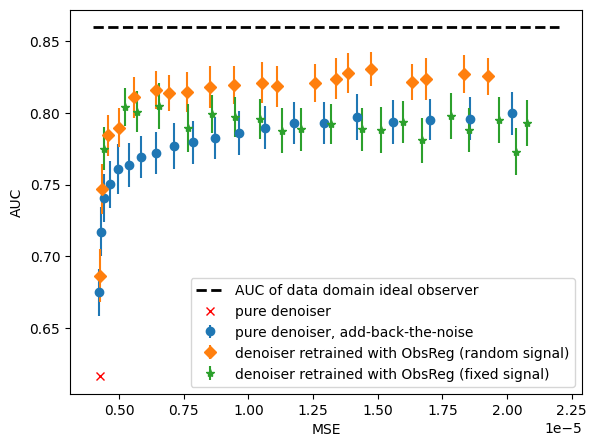

In [ ]:
print(mse_addnoise[0], auc_addnoise[0])
fig4 = plt.figure()
ax=fig4.add_axes([0.15,0.15,0.8,0.8])

#maxaucline = ax.plot([0.4e-5, 2.2e-5], [0.811, 0.811], color='k', linestyle='--', linewidth=2, label='AUC of FBP') #This was the old fbp baseline
#maxaucline = ax.plot([0.4e-5, 2.2e-5], [0.8053, 0.8053], color='k', linestyle='--', linewidth=2, label='AUC of FBP') #this is based on bootstrap of fbp
maxaucline = ax.plot([0.4e-5, 2.2e-5], [0.86, 0.86], color='k', linestyle='--', linewidth=2, label='AUC of data domain ideal observer')

e1 = plt.errorbar(mse_addnoise[1:],auc_addnoise[1:], std_addnoise[1:], fmt='o', label='pure denoiser, add-back-the-noise')
e4 = plt.plot(mse_addnoise[0], auc_addnoise[0],'rx', label='pure denoiser')

e2 = plt.errorbar(sig_1000_mse, sig_1000_auc, sig_1000_std, fmt='D', label='denoiser retrained with ObsReg (random signal)')
e3 = plt.errorbar(sig_1_mse, sig_1_auc, sig_1_std, fmt='*', label = 'denoiser retrained with ObsReg (fixed signal)')


ax.legend(loc='lower right')
ax.set_xlabel('MSE')
ax.set_ylabel('AUC')
plt.show()
fig4.savefig(PATH+'/final_plots/mse_v_auc.pdf')


Run visual comparison figure part 1: identify lambdas and generate/store test images

In [ ]:
#first identify lambda levels with similar mse for add-back-the-noise, fixed signal retrained CNN, and random signal retrained CNN
print('add back')
print(mse_addnoise)
print('fixed signal')
print(sig_1_mse)
print('random signal')
print(sig_1000_mse)


add back
[4.25690277e-06 4.22426651e-06 4.27899480e-06 4.42121707e-06
 4.65073008e-06 4.96704059e-06 5.37140490e-06 5.86264490e-06
 6.44099562e-06 7.10640566e-06 7.86022281e-06 8.70063463e-06
 9.62758821e-06 1.06427274e-05 1.17450658e-05 1.29348776e-05
 1.42110703e-05 1.55759949e-05 1.70273426e-05 1.85654025e-05
 2.01916651e-05]
fixed signal
[4.39558786e-06 5.23247950e-06 5.69351724e-06 6.55615195e-06
 7.66788382e-06 8.58804117e-06 9.46442075e-06 1.04599180e-05
 1.12814716e-05 1.20215519e-05 1.31810656e-05 1.43986537e-05
 1.51351290e-05 1.59716480e-05 1.67061929e-05 1.78477506e-05
 1.85271609e-05 1.96903364e-05 2.03512392e-05 2.07581071e-05]
random signal
[4.24208890e-06 4.33106084e-06 4.56436962e-06 5.00928330e-06
 5.58902306e-06 6.41600305e-06 6.93580664e-06 7.62962847e-06
 8.50060562e-06 9.46037347e-06 1.05057801e-05 1.10925389e-05
 1.25611075e-05 1.33963235e-05 1.38645680e-05 1.47233743e-05
 1.68774521e-05 1.63156667e-05 1.83172380e-05 1.92560000e-05]


low MSE =4.3e-6 --> add_back 2, fixed 0, random 1 //
mid 1 MSE = 5.7e-6 --> add_back 7, fixed 2, random 4 //
mid 2 MSE = 8.5e-5 --> add_back 11, fixed 5, random 8 //
mid 3 MSE = 1e-5 --> add back 13, fixed 7, random 10 //
high MSE = 1.4e-5 --> add back 16, fixed 11, random 14 //
idea lambdas?[link text](https://)

In [ ]:

alphavec = np.linspace(0.0,0.2,21, dtype='float32')
net=loadBaseNet()
test_add_back(net,0)
test_add_back(net, alphavec[2])
test_add_back(net, alphavec[7])
test_add_back(net, alphavec[11])
test_add_back(net, alphavec[13])
test_add_back(net, alphavec[16])
test_add_back(net, 0.5)

test denoised MSE: 0.00000426
test denoised AUC: 0.5369
test denoised MSE: 0.00000432
test denoised AUC: 0.6638
test denoised MSE: 0.00000599
test denoised AUC: 0.7577
test denoised MSE: 0.00000889
test denoised AUC: 0.7761
test denoised MSE: 0.00001086
test denoised AUC: 0.7817
test denoised MSE: 0.00001447
test denoised AUC: 0.7883
test denoised MSE: 0.00011004
test denoised AUC: 0.8076


(0.00011003575244831154, 0.807604)

Note: even at alpha = 0.5, the AUC does not exceed the AUC of the fbp.

add_back_alpha_0.019999999552965164
fbp MSE:      0.00043060
denoised MSE: 0.00000866
add_back_alpha_0.07000000029802322
fbp MSE:      0.00043060
denoised MSE: 0.00000997
add_back_alpha_0.10999999940395355
fbp MSE:      0.00043060
denoised MSE: 0.00001259
add_back_alpha_0.1599999964237213
fbp MSE:      0.00043060
denoised MSE: 0.00001781
random signals lambda = 0.002:
fbp MSE:      0.00043060
denoised MSE: 0.00000846
test denoised MSE: 0.00000437
test denoised AUC: 0.7491
random signals lambda = 0.005:
fbp MSE:      0.00043060
denoised MSE: 0.00000922
test denoised MSE: 0.00000563
test denoised AUC: 0.7776
random signals lambda = 0.009000000000000001:
fbp MSE:      0.00043060
denoised MSE: 0.00001179
test denoised MSE: 0.00000873
test denoised AUC: 0.7904
random signals lambda = 0.015:
fbp MSE:      0.00043060
denoised MSE: 0.00001713
test denoised MSE: 0.00001426
test denoised AUC: 0.7983
fixed signals lambda = 0.001:
fbp MSE:      0.00043060
denoised MSE: 0.00000928
test denoised MSE

(1.3714364109091549e-05, 0.763252)

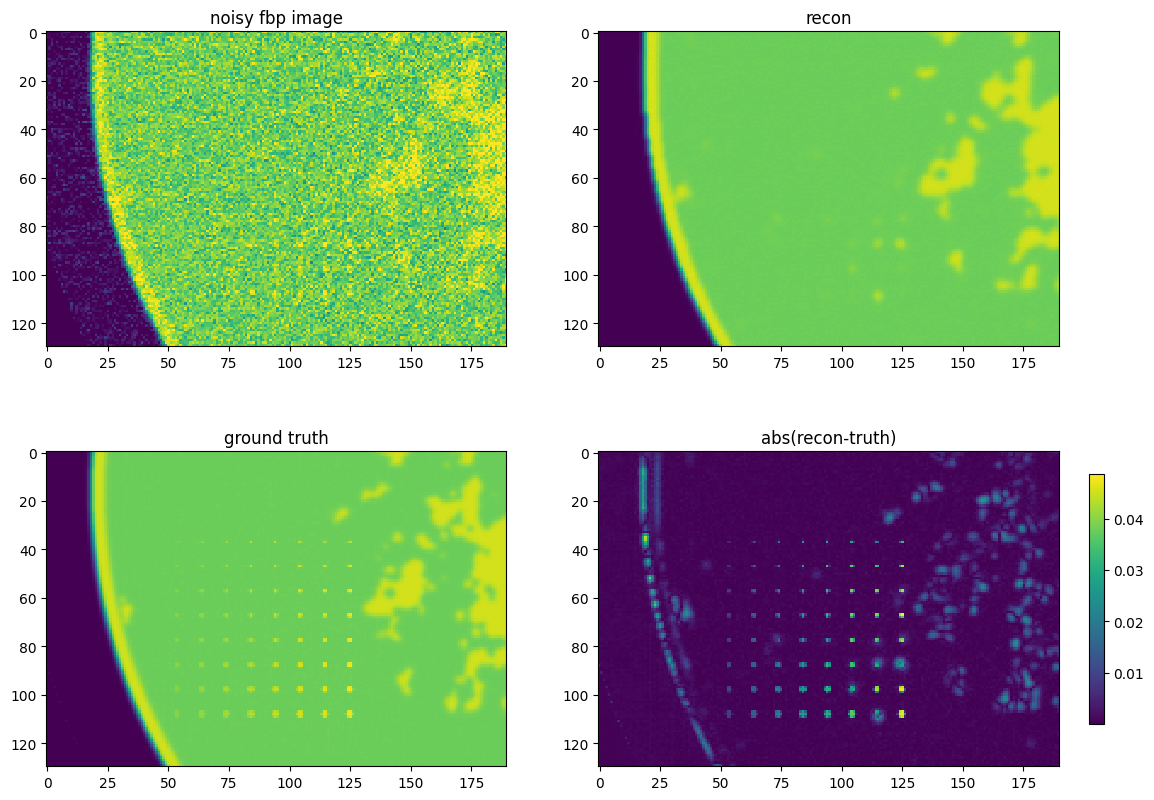

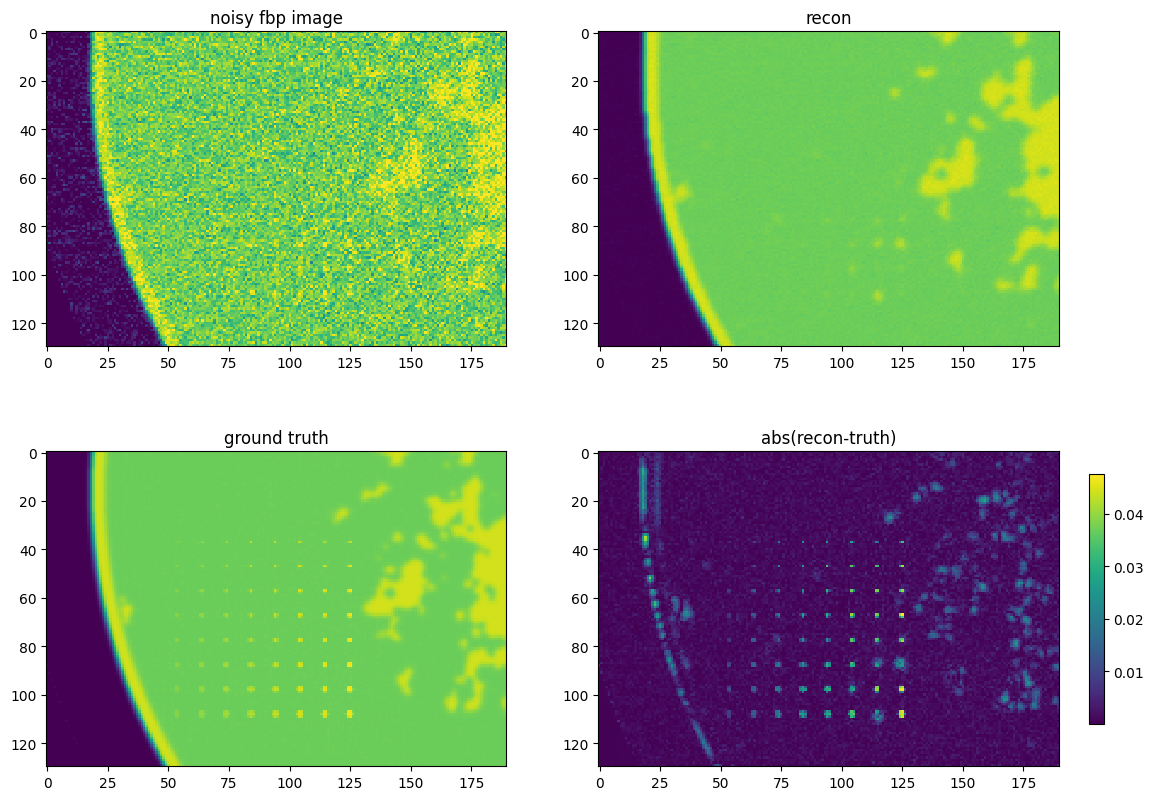

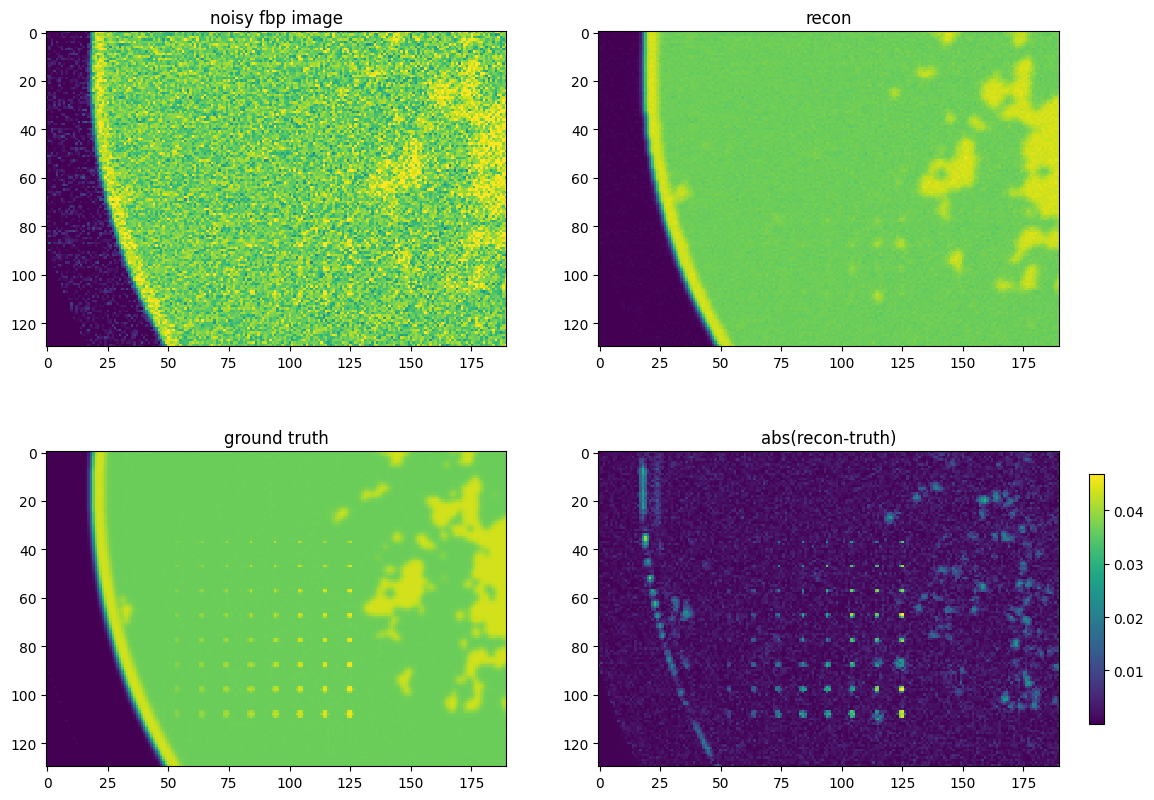

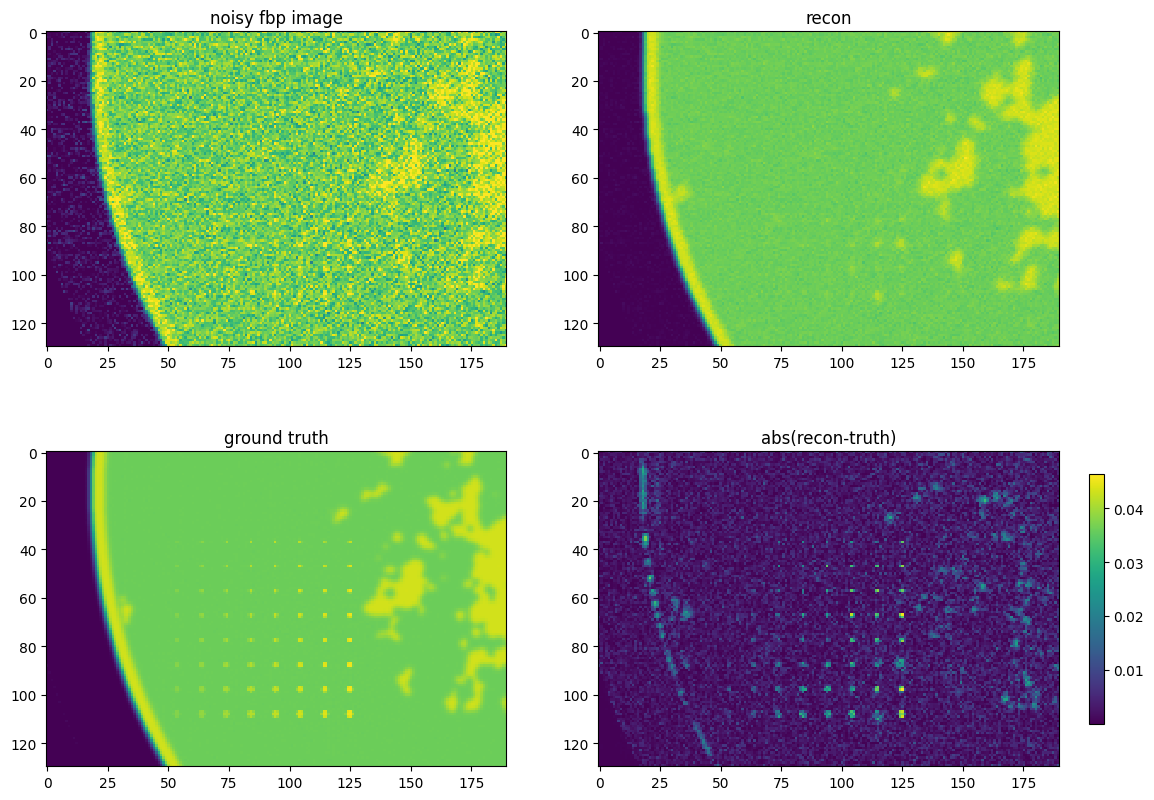

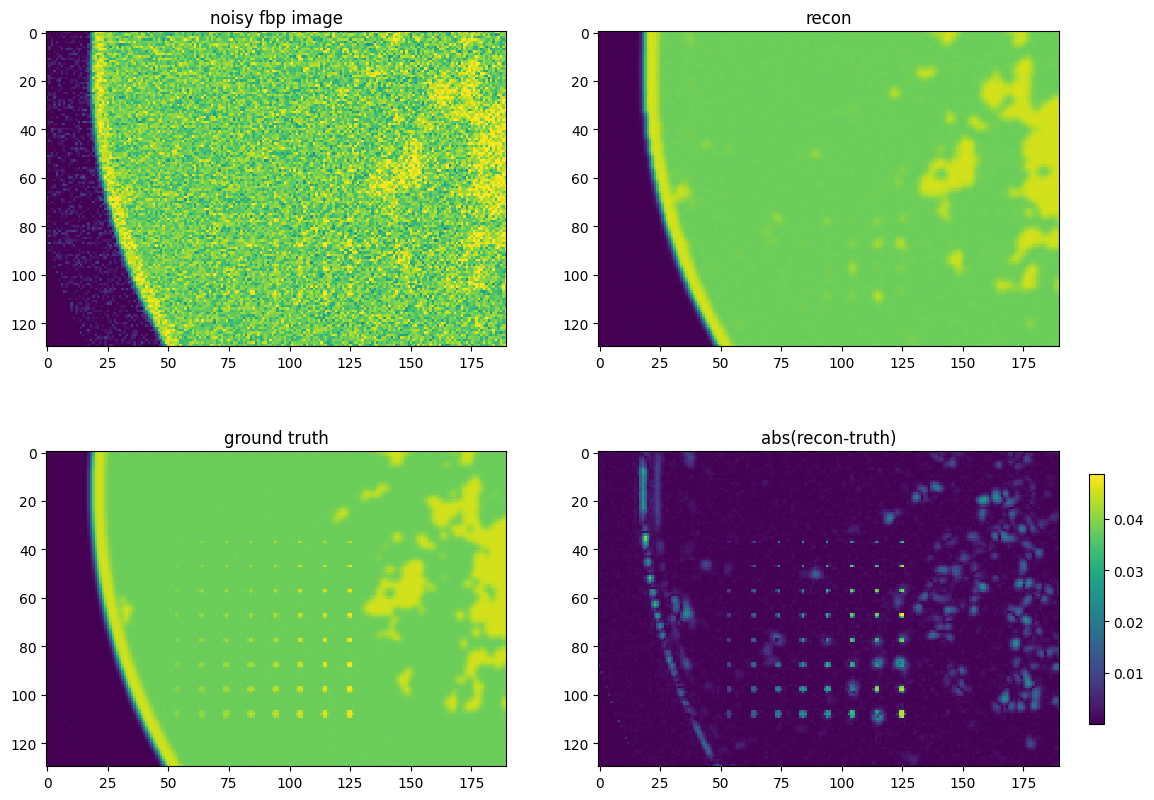

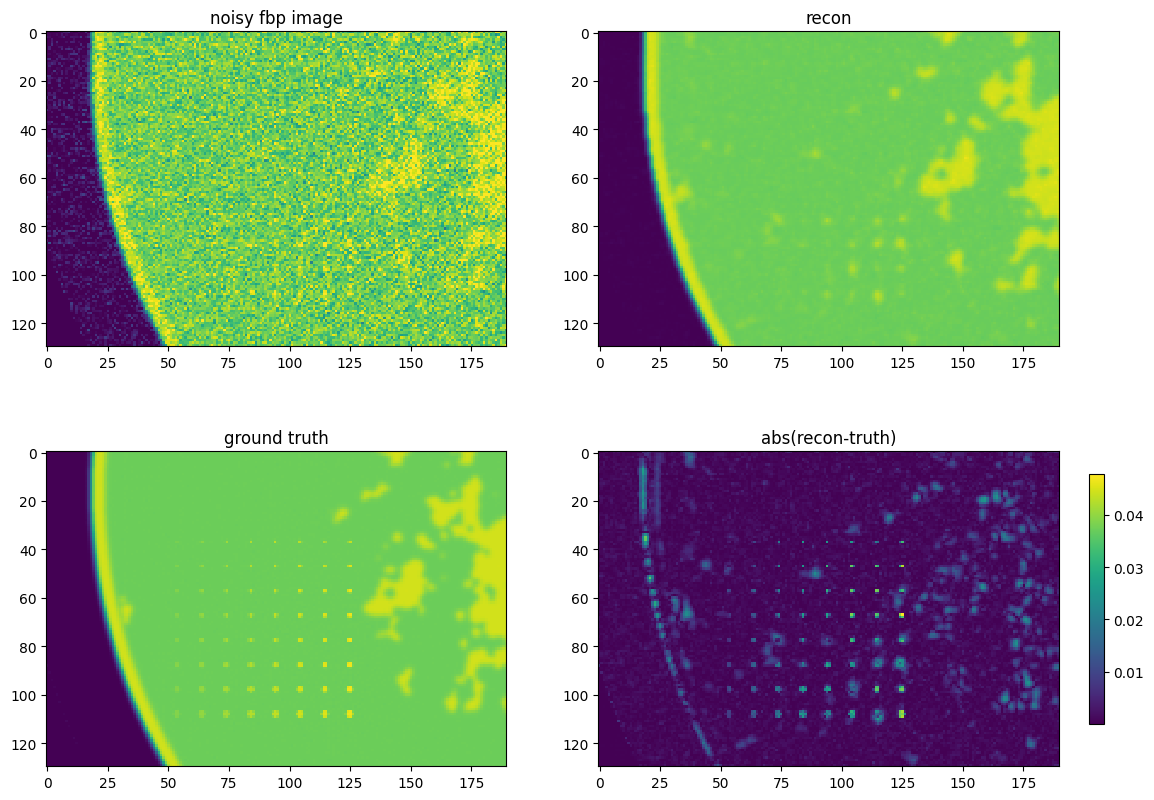

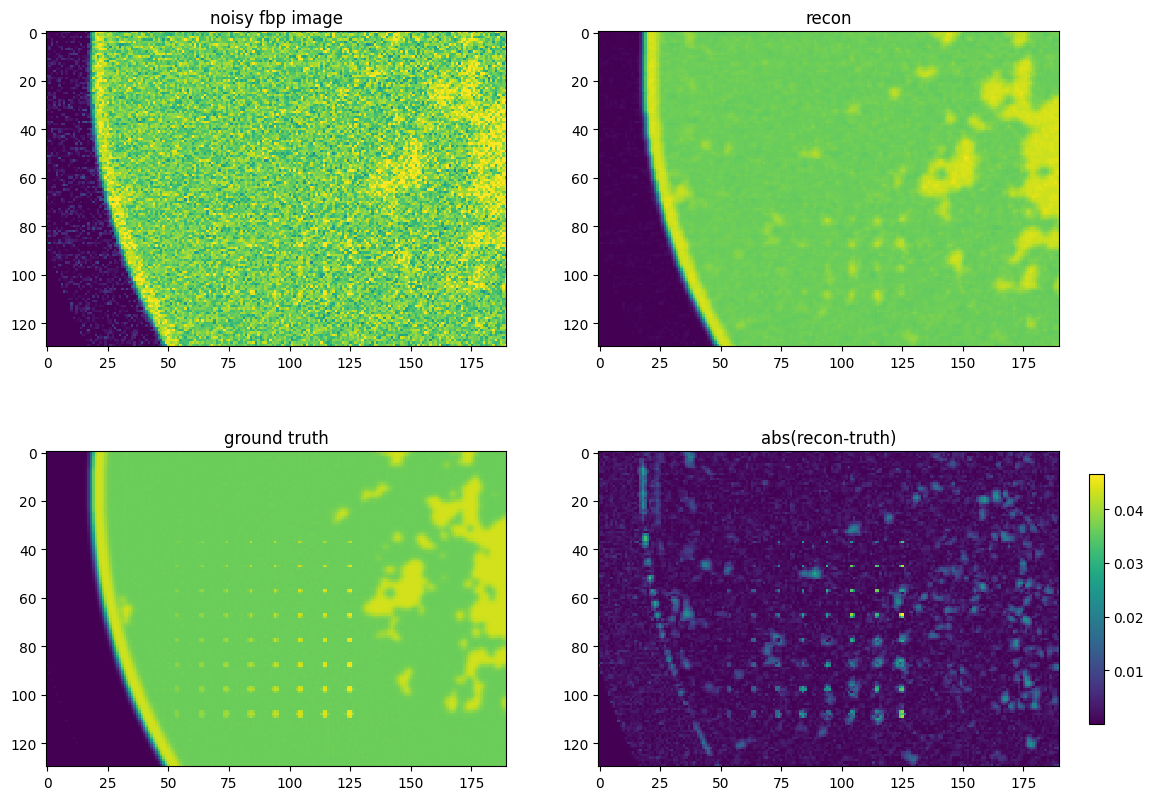

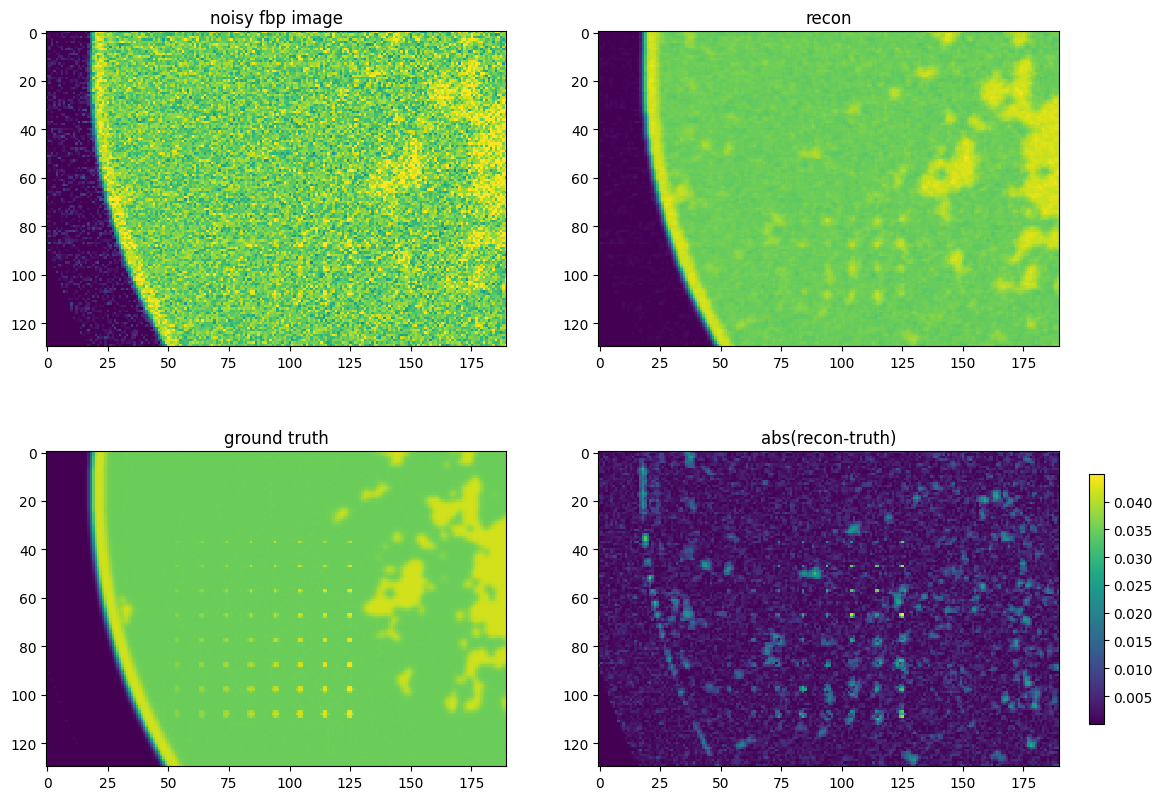

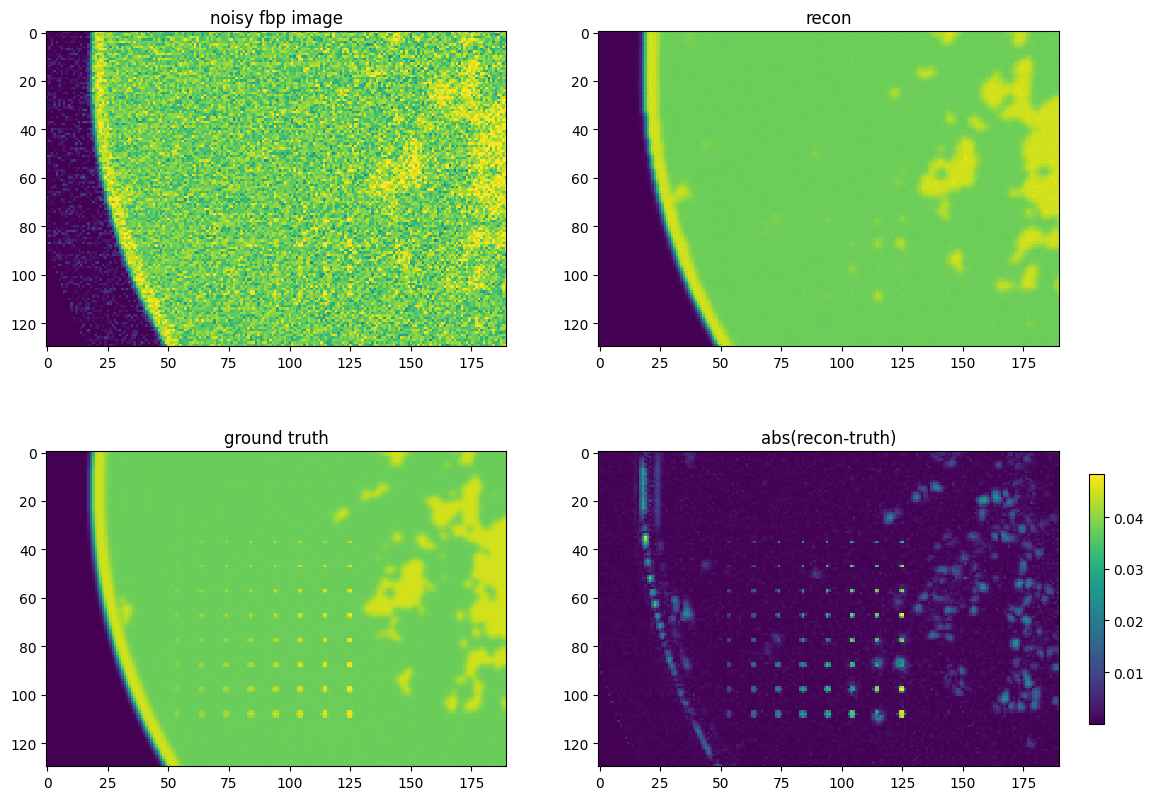

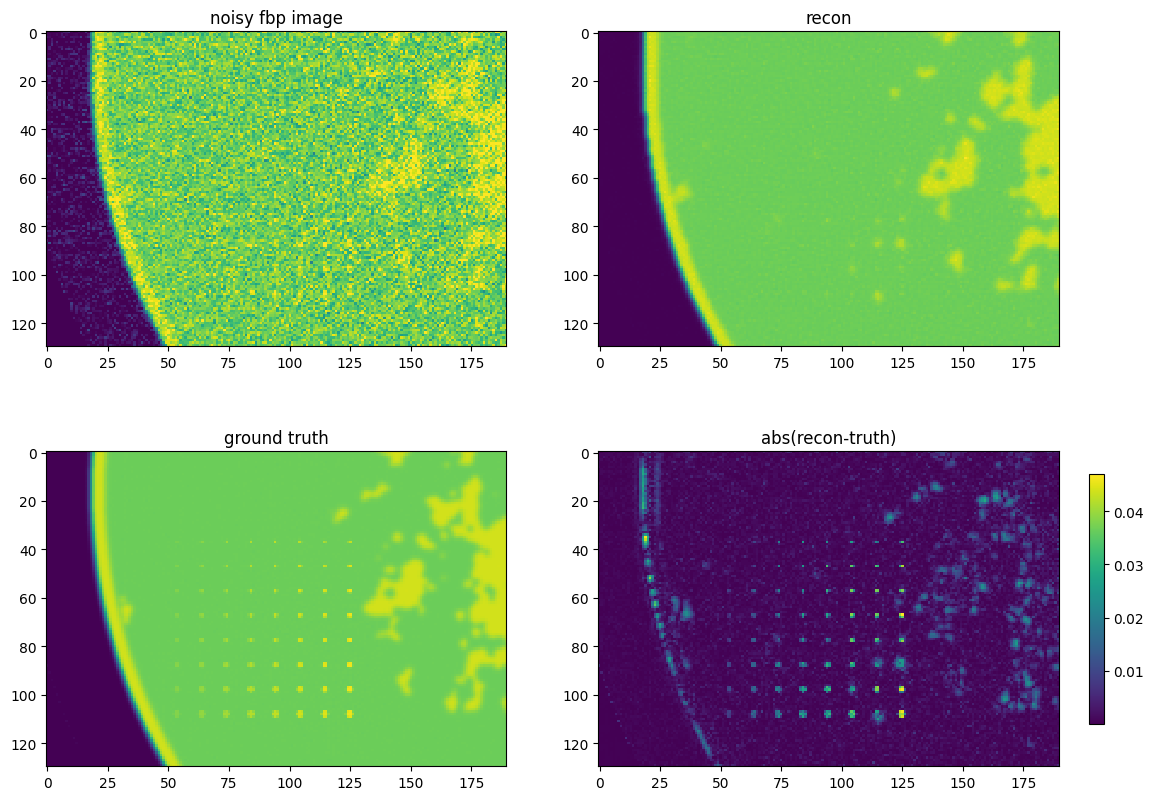

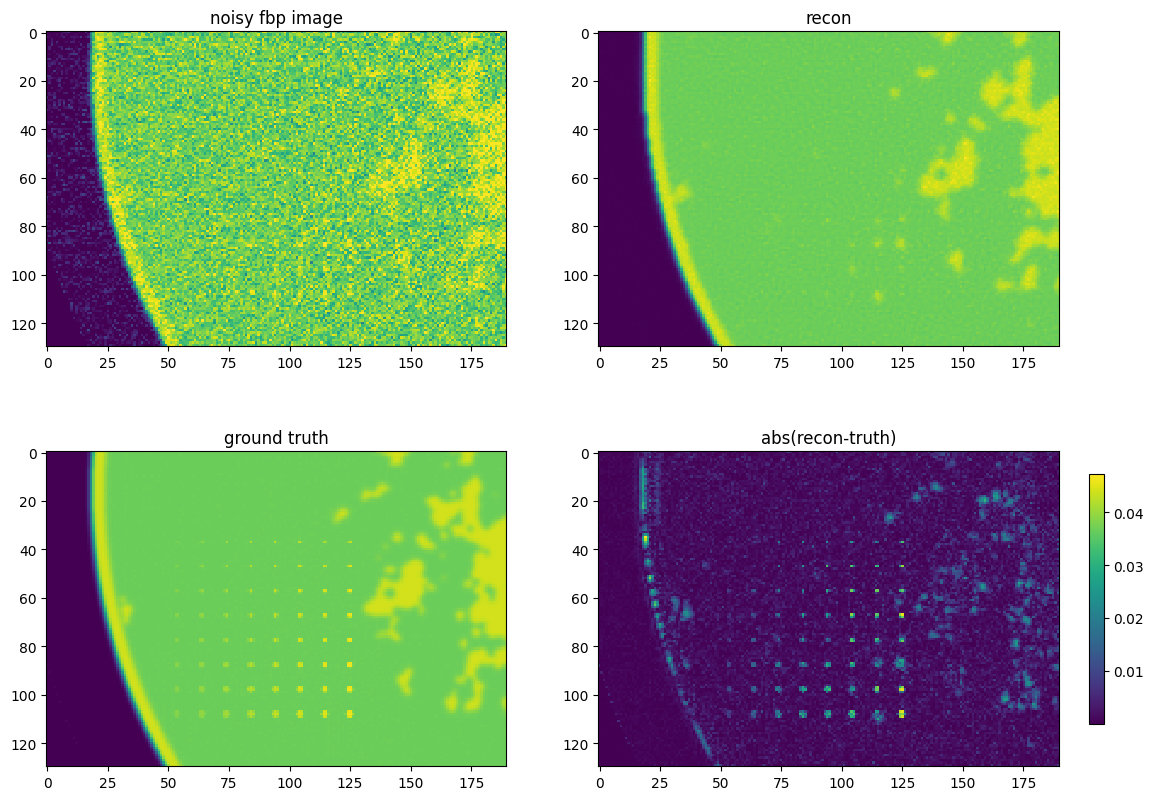

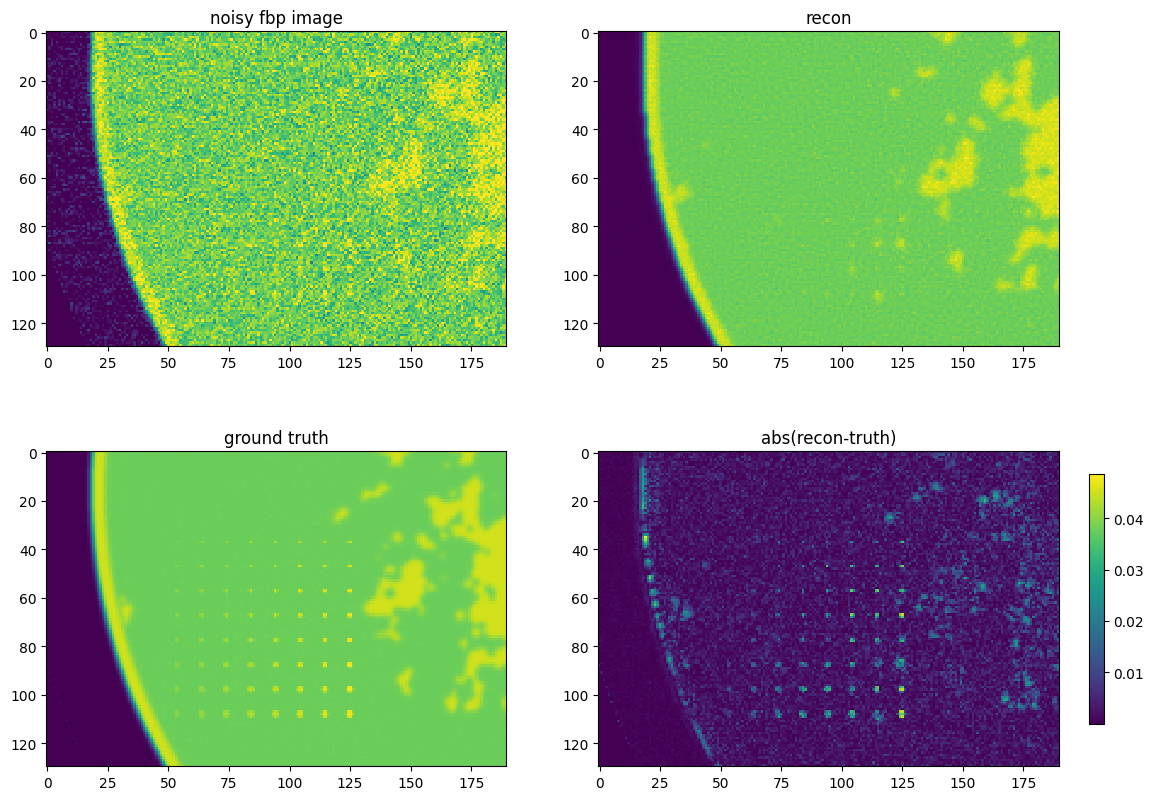

In [ ]:
#generate and store images for each model at the specified lambda level
lambda_set = np.linspace(1e-3,2e-2,20)
alphavec = np.linspace(0.0,0.2,21, dtype='float32')
#add-back model
temp_net=loadBaseNet()
print(f'add_back_alpha_{alphavec[2]}')
denoise_single_test_add_back(temp_net, alphavec[2], True, True, PATH+'/final_plots/add_back_DEMO_LOWEST_MSE.npy')
print(f'add_back_alpha_{alphavec[7]}')
denoise_single_test_add_back(temp_net, alphavec[7], True, True, PATH+'/final_plots/add_back_DEMO_MID1_MSE.npy')
print(f'add_back_alpha_{alphavec[11]}')
denoise_single_test_add_back(temp_net, alphavec[11],True, True, PATH+'/final_plots/add_back_DEMO_MID2_MSE.npy')
print(f'add_back_alpha_{alphavec[16]}')
denoise_single_test_add_back(temp_net, alphavec[16], True, True, PATH+'/final_plots/add_back_DEMO_HIGH_MSE.npy')


temp_net=loadBaseNet()
print(f'random signals lambda = {lambda_set[1]}:')
f_name=f"/sig_1000_lam_{lambda_set[1]}_"
trained_weights=torch.load(PATH+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/RANDOM_SIG_DEMO_LOWEST_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'random signals lambda = {lambda_set[4]}:')
f_name=f"/sig_1000_lam_{lambda_set[4]}_"
trained_weights=torch.load(PATH+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/RANDOM_SIG_DEMO_MID1_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'random signals lambda = {lambda_set[8]}:')
f_name=f"/sig_1000_lam_{lambda_set[8]}_"
trained_weights=torch.load(PATH+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/RANDOM_SIG_DEMO_MID2_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'random signals lambda = {lambda_set[14]}:')
f_name=f"/sig_1000_lam_{lambda_set[14]}_"
trained_weights=torch.load(PATH+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/RANDOM_SIG_DEMO_HIGH_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'fixed signals lambda = {lambda_set[0]}:')
f_name=f"/sig_1_lam_{lambda_set[0]}_"
trained_weights=torch.load(PATH+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/FIXED_SIG_DEMO_LOWEST_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'fixed signals lambda = {lambda_set[1]}:')
f_name=f"/sig_1_lam_{lambda_set[1]}_"
trained_weights=torch.load(PATH+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/FIXED_SIG_DEMO_MID1_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'fixed signals lambda = {lambda_set[2]}:')
f_name=f"/sig_1_lam_{lambda_set[2]}_"
trained_weights=torch.load(PATH+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/FIXED_SIG_DEMO_MID2_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'fixed signals lambda = {lambda_set[4]}:')
f_name=f"/sig_1_lam_{lambda_set[4]}_"
trained_weights=torch.load(PATH+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/FIXED_SIG_DEMO_HIGH_MSE.npy')
test_net(temp_net)


Run visual comparison figure part 2:combine test images into single plot

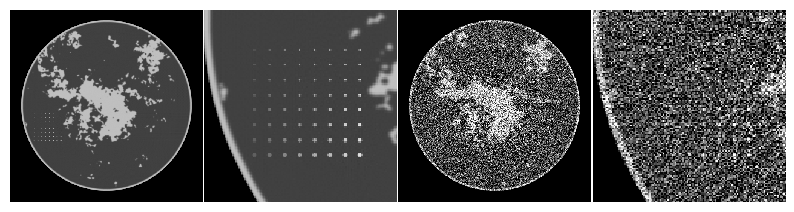

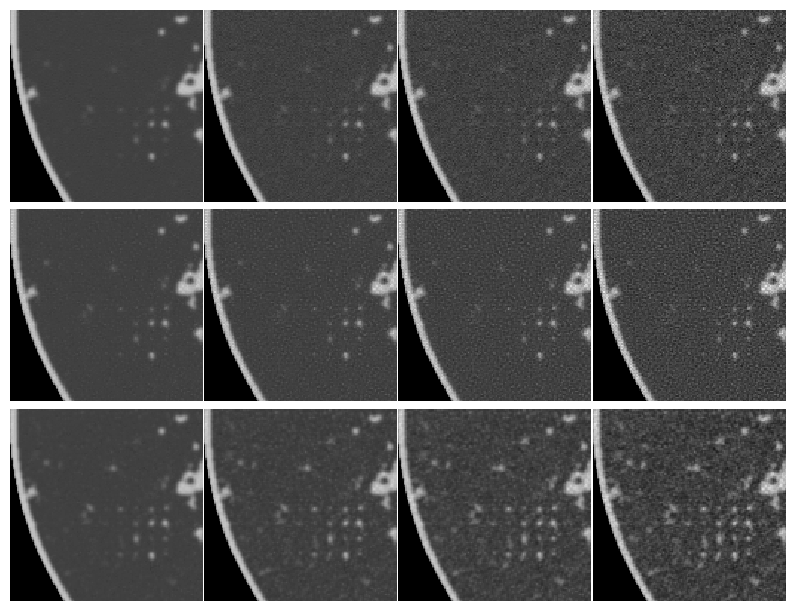

In [ ]:
DATADIR = "/data/singledata512smoothObj_nph4e10/"

noisy_image = np.load(PATH+DATADIR+"fbp_128view_noisy.npy")
truth_image  = np.load(PATH+DATADIR+"fbp_1024view_noiseless.npy")
denoised_image0 = np.load(PATH+"/final_plots/FIXED_SIG_DEMO_LOWEST_MSE.npy")
denoised_image1 = np.load(PATH+"/final_plots/FIXED_SIG_DEMO_MID1_MSE.npy")
denoised_image2 = np.load(PATH+"/final_plots/FIXED_SIG_DEMO_MID2_MSE.npy")
denoised_image3 = np.load(PATH+"/final_plots/FIXED_SIG_DEMO_HIGH_MSE.npy")

denoised_image4 = np.load(PATH+"/final_plots/RANDOM_SIG_DEMO_LOWEST_MSE.npy")
denoised_image5 = np.load(PATH+"/final_plots/RANDOM_SIG_DEMO_MID1_MSE.npy")
denoised_image6 = np.load(PATH+"/final_plots/RANDOM_SIG_DEMO_MID2_MSE.npy")
denoised_image7 = np.load(PATH+"/final_plots/RANDOM_SIG_DEMO_HIGH_MSE.npy")

denoised_image8 = np.load(PATH+"/final_plots/add_back_DEMO_LOWEST_MSE.npy")
denoised_image9 = np.load(PATH+"/final_plots/add_back_DEMO_MID1_MSE.npy")
denoised_image10 = np.load(PATH+"/final_plots/add_back_DEMO_MID2_MSE.npy")
denoised_image11 = np.load(PATH+"/final_plots/add_back_DEMO_HIGH_MSE.npy")

mask = np.zeros_like(noisy_image).astype('bool')
mask[250:380,30:160] = True

truth_image_clip = truth_image[mask].reshape((130,130))
noisy_image_clip = noisy_image[mask].reshape((130,130))
denoised_image0_clip = denoised_image0[mask].reshape((130,130))
denoised_image1_clip = denoised_image1[mask].reshape((130,130))
denoised_image2_clip = denoised_image2[mask].reshape((130,130))
denoised_image3_clip = denoised_image3[mask].reshape((130,130))

denoised_image4_clip = denoised_image4[mask].reshape((130,130))
denoised_image5_clip = denoised_image5[mask].reshape((130,130))
denoised_image6_clip = denoised_image6[mask].reshape((130,130))
denoised_image7_clip = denoised_image7[mask].reshape((130,130))

denoised_image8_clip = denoised_image8[mask].reshape((130,130))
denoised_image9_clip = denoised_image9[mask].reshape((130,130))
denoised_image10_clip = denoised_image10[mask].reshape((130,130))
denoised_image11_clip = denoised_image11[mask].reshape((130,130))


alpha = 0.0
fig, ax = plt.subplots(1, 4, figsize=(10,10))

lim = [0.174, 0.253]

ax[0].imshow(truth_image,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[0].set_title('Clean Image')
ax[1].imshow(truth_image_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[1].set_title('Clean Image Zoom')
#ax[2].set_title('Noisy FBP Image')
ax[2].imshow(noisy_image,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[3].set_title('Noisy FBP Image Zoom')
ax[3].imshow(noisy_image_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')

for a in ax.flatten():  # turns off axes
  a.axis("off")
  a.axis("tight")  # gets rid of white border
  a.axis("image")  # square up the image instead of filling the "figure" space
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.17, 0.01, 0.25])
# fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig(PATH+'/final_plots/noisy_clean_clips.pdf')
plt.show()

fig, ax = plt.subplots(3, 4, figsize=(10,8))

ax[0,0].imshow(denoised_image8_clip,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[0,0].set_title('Low lambda',wrap=True)
ax[0,1].imshow(denoised_image9_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[0,1].set_title('IDEAL lambda',wrap=True)
ax[0,2].imshow(denoised_image10_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[0,2].set_title('Mid lambda',wrap=True)
ax[0,3].imshow(denoised_image11_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[0,3].set_title('High lamda',wrap=True)

#ax[1,0].set_title('Random Signal ObsLoss Retrained Network')
ax[1,0].imshow(denoised_image0_clip,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[2,0].set_title('Low lamda',wrap=True)
ax[1,1].imshow(denoised_image1_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[2,1].set_title('IDEAL lambda',wrap=True)
ax[1,2].imshow(denoised_image2_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[2,2].set_title('Mid MSE',wrap=True)
ax[1,3].imshow(denoised_image3_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[2,3].set_title('High MSE',wrap=True)


#ax[2,0].set_title('Fixed Signal ObsLoss Retrained Network')
ax[2,0].imshow(denoised_image4_clip,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[3,0].set_title('Low MSE',wrap=True)
ax[2,1].imshow(denoised_image5_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[3,1].set_title('IDEAL',wrap=True)
ax[2,2].imshow(denoised_image6_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[3,2].set_title('Mid MSE',wrap=True)
ax[2,3].imshow(denoised_image7_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
#ax[3,3].set_title('High MSE',wrap=True)


for a in ax.flatten():  # turns off axes
  a.axis("off")
  a.axis("tight")  # gets rid of white border
  a.axis("image")  # square up the image instead of filling the "figure" space
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.17, 0.01, 0.25])
# fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(wspace=0.01, hspace=-0.08)
plt.savefig(PATH+'/final_plots/demo_images.pdf')

run laplacian testing figures

add back ideal alpha = 0.029999999329447746
fixed signal obs reg ideal lambda = 0.007
random signal obs reg ideal lamda = 0.005


<ipython-input-4-b214afa9d9a5>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


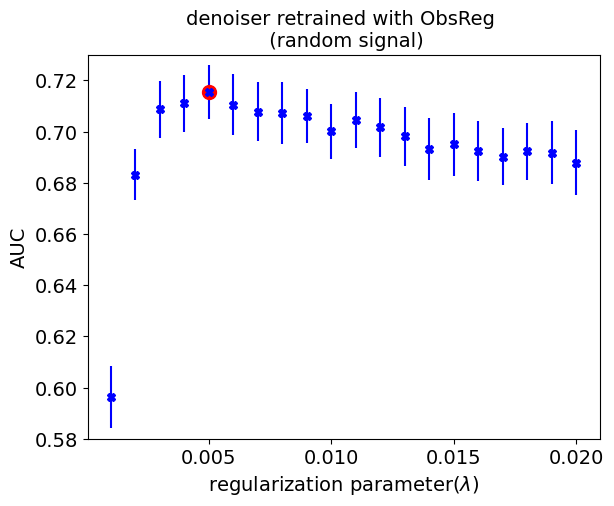

<ipython-input-4-b214afa9d9a5>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


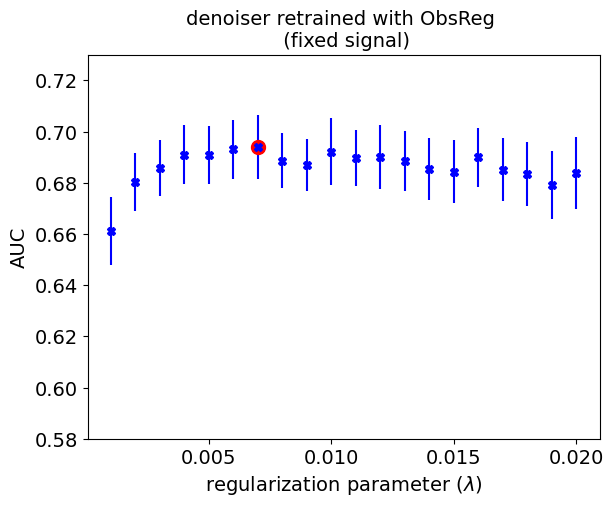

<ipython-input-4-b214afa9d9a5>:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


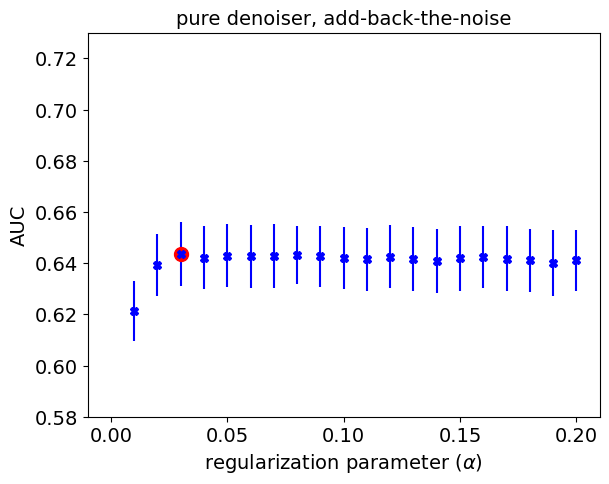

In [4]:
lambda_set = np.linspace(1e-3,2e-2,20)
alphavec = np.linspace(0.0,0.2,21, dtype='float32')

print(f'add back ideal alpha = {alphavec[3]}')
print(f'fixed signal obs reg ideal lambda = {lambda_set[6]}')
print(f'random signal obs reg ideal lamda = {lambda_set[4]}')

fig1 = plt.figure()
ax=fig1.add_axes([0.2,0.2,0.8,0.8])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
e1 = plt.errorbar(lambda_set, lap_sig_1000_auc, lap_sig_1000_std, fmt='bX')
plt.plot(lambda_set[4], lap_sig_1000_auc[4],'or',markersize=10)
ax.set_xlabel(r'regularization parameter($\lambda$)', fontsize=14)
ax.set_ylabel('AUC', fontsize=14)
ax.set_title('denoiser retrained with ObsReg \n (random signal)', fontsize=14)
ax.set_ylim([0.58,0.73])
plt.tight_layout()
plt.savefig(PATH+'/final_plots/lap_lambda_AUC_random.pdf',bbox_inches='tight')
plt.show()

####MSE vs AUC plot
#fig2=plt.figure()
#ax=fig2.add_axes([0,0,1,1])
#e6 = plt.errorbar(lap_sig_1000_mse, lap_sig_1000_auc, lap_sig_1000_std, fmt='X')
#plt.plot(lap_sig_1000_mse[4], lap_sig_1000_auc[4],'or',markersize=10)
#ax.set_xlabel('MSE')
#ax.set_ylabel('AUC')
#ax.set_title('Laplacian Testing -Random Signal Re-Trained Denoising CNN')
#ax.set_ylim([0.58,0.73])
#plt.show()

fig3 = plt.figure()
ax=fig3.add_axes([0.2,0.2,0.8,0.8])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
e1 = plt.errorbar(lambda_set, lap_sig_1_auc, lap_sig_1_std, fmt='bX')
plt.plot(lambda_set[6], lap_sig_1_auc[6],'or',markersize=10)
ax.set_xlabel(r'regularization parameter ($\lambda$)', fontsize=14)
ax.set_ylabel('AUC', fontsize=14)
ax.set_title('denoiser retrained with ObsReg \n (fixed signal)', fontsize=14)
ax.set_ylim([0.58,0.73])
plt.tight_layout()
plt.savefig(PATH+'/final_plots/lap_lambda_AUC_fixed.pdf',bbox_inches='tight')
plt.show()

####MSE vs AUC plot
#fig4=plt.figure()
#ax=fig4.add_axes([0,0,1,1])
#e6 = plt.errorbar(lap_sig_1_mse, lap_sig_1_auc, lap_sig_1_std, fmt='X')
#plt.plot(lap_sig_1_mse[6], lap_sig_1_auc[6],'or',markersize=10)
#ax.set_xlabel('MSE')
#ax.set_ylabel('AUC')
#ax.set_title('Laplacian Testing - Fixed Signal Re-Trained Denoising CNN')
#ax.set_ylim([0.58,0.73])
#plt.show()

#ADD BACK PLOTS
fig5 = plt.figure()
ax=fig5.add_axes([0.2,0.2,0.8,0.8])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
e1 = plt.errorbar(alphavec, lap_add_back_auc, lap_add_back_std, fmt='bX')
plt.plot(alphavec[3], lap_add_back_auc[3],'or',markersize=10)
ax.set_xlabel(r'regularization parameter ($\alpha$)', fontsize=14) #use alpha symbol?
ax.set_ylabel('AUC', fontsize=14)
ax.set_title('pure denoiser, add-back-the-noise', fontsize=14)
ax.set_ylim([0.58,0.73])
plt.tight_layout()
plt.savefig(PATH+'/final_plots/lap_lambda_AUC_add_back.pdf',bbox_inches='tight')
plt.show()

####MSE vs AUC plot
#fig6=plt.figure()
#ax=fig6.add_axes([0,0,1,1])
#e6 = plt.errorbar(lap_add_back_mse, lap_add_back_auc, lap_add_back_std, fmt='X')
#plt.plot(lap_add_back_mse[3], lap_add_back_auc[3],'or',markersize=10)
#ax.set_xlabel('MSE')
#ax.set_ylabel('AUC')
#ax.set_title('Laplacian Testing - Add-back-the-noise')
#ax.set_ylim([0.58,0.73])
#plt.show()
##ideal Reconstructions


reconstructed images at ideal lambdas based on laplacian testing

add_back_alpha_0.029999999329447746
fbp MSE:      0.00043060
denoised MSE: 0.00000874


<ipython-input-2-c9ca9c7b8717>:422: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  t_sig = torch.from_numpy(t_sig_real[k,np.newaxis,:,:]).detach().float().to(device)


test denoised MSE: 0.00000448
test denoised AUC: 0.6998
fixed signals lambda = 0.007:
fbp MSE:      0.00043060
denoised MSE: 0.00002450
test denoised MSE: 0.00001961
test denoised AUC: 0.7687
random signals lambda = 0.005:
fbp MSE:      0.00043060
denoised MSE: 0.00000922
test denoised MSE: 0.00000563
test denoised AUC: 0.7776


(5.62863518030099e-06, 0.777556)

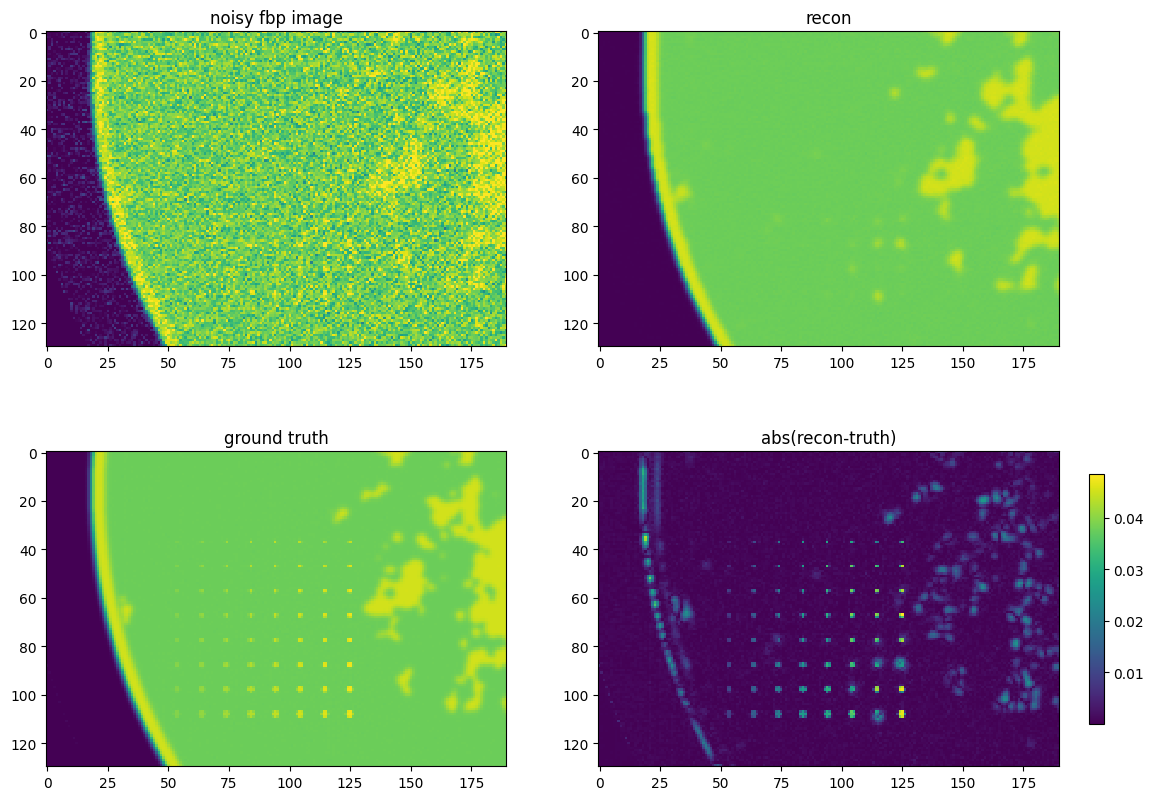

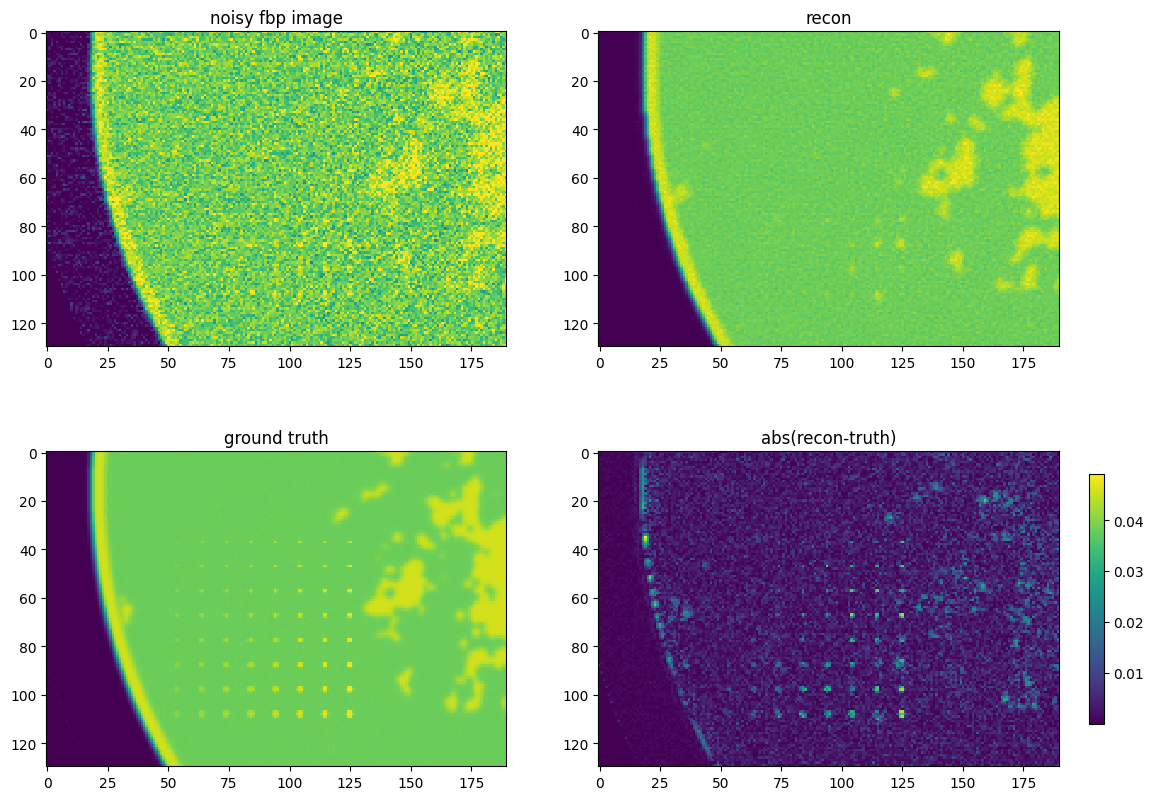

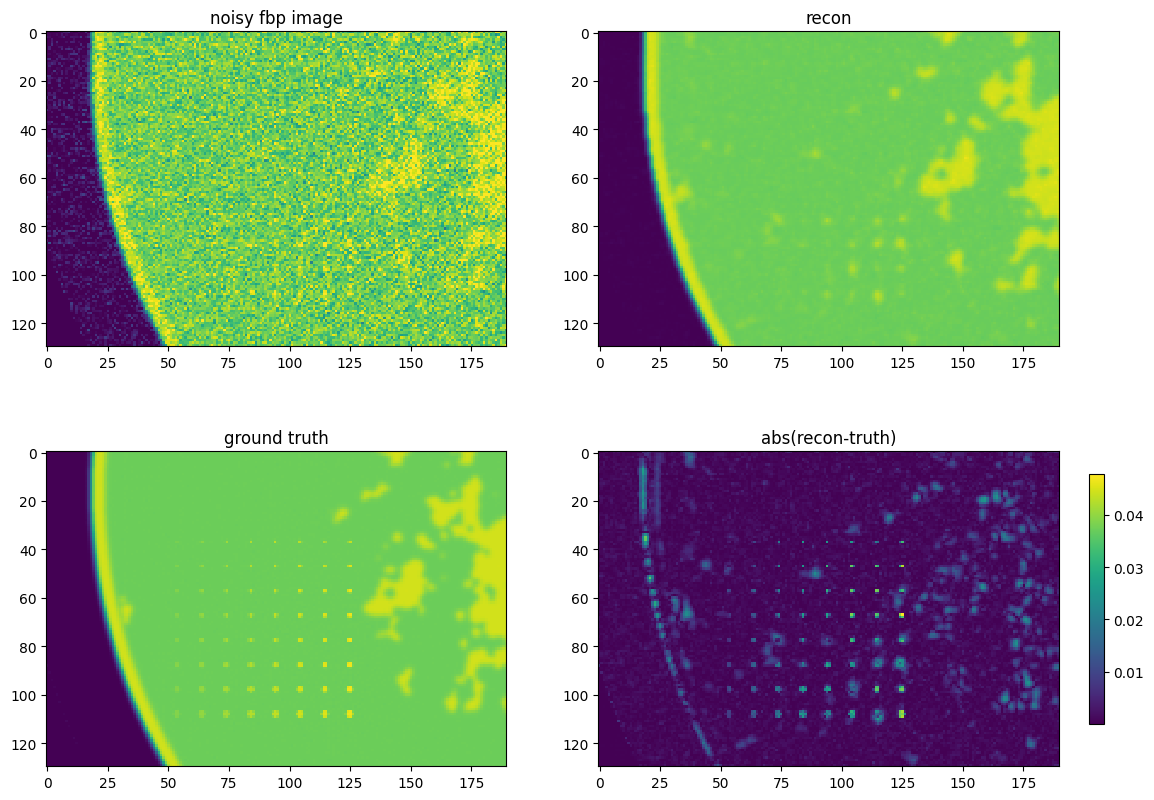

In [ ]:
alphavec = np.linspace(0.0,0.2,21, dtype='float32')
print(f'add_back_alpha_{alphavec[3]}')
temp_net=loadBaseNet()
denoise_single_test_add_back(temp_net, alphavec[3], True, True, PATH+'/final_plots/add_back_DEMO_IDEAL_MSE.npy')
test_add_back(temp_net, alphavec[3])

temp_net=loadBaseNet()
print(f'fixed signals lambda = {lambda_set[6]}:')
f_name=f"/sig_1_lam_{lambda_set[6]}_"
trained_weights=torch.load(PATH+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/FIXED_SIG_DEMO_IDEAL_MSE.npy')
test_net(temp_net)

temp_net=loadBaseNet()
print(f'random signals lambda = {lambda_set[4]}:')
f_name=f"/sig_1000_lam_{lambda_set[4]}_"
trained_weights=torch.load(PATH+f_name+"dict.pth",map_location=torch.device(device))
temp_net.load_state_dict(trained_weights)
denoise_single_test(temp_net, True, True, PATH+'/final_plots/RANDOM_SIG_DEMO_IDEAL_MSE.npy')
test_net(temp_net)

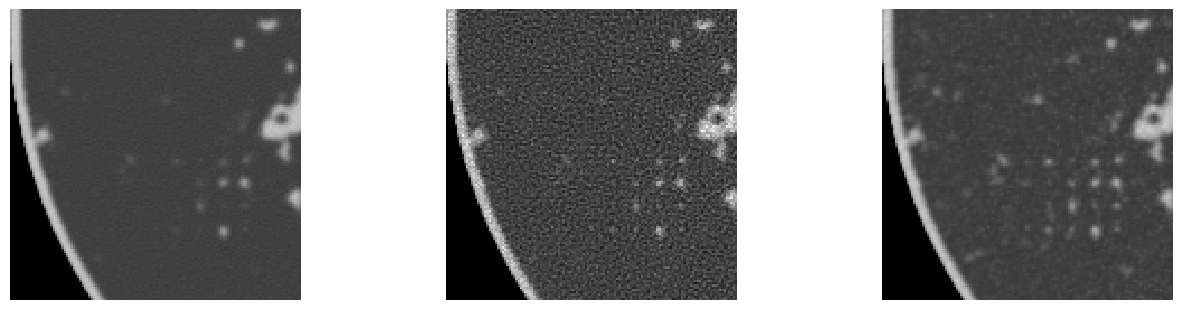

In [ ]:
DATADIR = "/data/singledata512smoothObj_nph4e10/"

noisy_image = np.load(PATH+DATADIR+"fbp_128view_noisy.npy")
truth_image  = np.load(PATH+DATADIR+"fbp_1024view_noiseless.npy")
denoised_image0 = np.load(PATH+"/final_plots/add_back_DEMO_IDEAL_MSE.npy")
denoised_image1 = np.load(PATH+"/final_plots/FIXED_SIG_DEMO_IDEAL_MSE.npy")
denoised_image2 = np.load(PATH+"/final_plots/RANDOM_SIG_DEMO_IDEAL_MSE.npy")




mask = np.zeros_like(noisy_image).astype('bool')
mask[250:380,30:160] = True

denoised_image0_clip = denoised_image0[mask].reshape((130,130))
denoised_image1_clip = denoised_image1[mask].reshape((130,130))
denoised_image2_clip = denoised_image2[mask].reshape((130,130))


alpha = 0.0
fig, ax = plt.subplots(1, 3, figsize=(15,15))

lim = [0.174, 0.253]

ax[0].imshow(denoised_image0_clip,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
ax[1].imshow(denoised_image1_clip, vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')
ax[2].imshow(denoised_image2_clip,vmin=lim[0],vmax=lim[1], interpolation='nearest', cmap='gray')


for a in ax.flatten():  # turns off axes
  a.axis("off")
 # a.axis("tight")  # gets rid of white border
  a.axis("image")  # square up the image instead of filling the "figure" space
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.17, 0.01, 0.25])
# fig.colorbar(im, cax=cbar_ax)
fig.subplots_adjust(wspace=0.5, hspace=0.01)
plt.savefig(PATH+'/final_plots/ideal_clips.pdf')
plt.show()

